# Quora Question Pairs 
*---by Donk , 2019.10*


## 1. Import Data

In [0]:
# import package
!pip install gensim
!pip install fuzzywuzzy
!pip install textblob
from fuzzywuzzy import fuzz
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, os, re, sys, datetime
from nltk.stem import WordNetLemmatizer     # 导入词性还原函数
from tqdm import tqdm_notebook as TQ
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from gensim.models import KeyedVectors
from scipy.spatial.distance import euclidean,cityblock,chebyshev,jaccard,cosine,canberra,braycurtis,minkowski
from scipy.stats import skew, kurtosis
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk, random
from wordcloud import WordCloud
from gensim.models.fasttext import FastText
random.seed(1)
# create file
try:
    os.makedirs('/content/drive/My Drive/figure')
    os.makedirs('/content/drive/My Drive/model')
    os.makedirs('/content/drive/My Drive/data')
except: pass
# set path
FigurePath = r'/content/drive/My Drive/figure'
ModelPath = r'/content/drive/My Drive/model'
datapath = r'/content/drive/My Drive/data'
SavePath = datapath + '/PreTrain.csv'           # 储存预处理后的数据
TestSavePath =  datapath + '/PreTest.csv'
TrainPath = datapath + '/train.csv'
TestPath = datapath + '/test.csv'
NA_DF_Path = datapath + '/NA_id.csv'
ProTrain = datapath + '/ProTrain.csv'
ProTest = datapath + '/ProTest.csv'
filename = datapath + '/GoogleNews-vectors-negative300.bin'     #　google pre-trained word2vec
def load_data():
    RawDF = pd.read_csv(TrainPath,keep_default_na=False).astype('object')
    TestDF = pd.read_csv(TestPath,encoding='utf-8',index_col='test_id',keep_default_na=False)
    RawDF = RawDF.set_index('id')                             # 设置id为索引
    RawDF.drop(columns=['qid1','qid2'],inplace=True)                    # 去掉qid列
    return RawDF,TestDF
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
StopWords = stopwords.words("english") 
WNL = WordNetLemmatizer()
pad=35

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
RawDF,TestDF = load_data()
pd.read_csv(TrainPath,keep_default_na=False).astype('object').sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
155072,155072,243012,243013,How good is www.1-800-sports.in?,Is tag rugby a good sport to take up?,0
135416,135416,216261,216262,How different is the philosophy of GoogleX fro...,Which is a better place to work: Samsung Resea...,0
77944,77944,48856,133000,What are some of the most overrated movies in ...,What was the most overrated movie of 2015 and ...,0
224764,224764,104901,152507,What is the best way to learn and practice C p...,How do I practice C programming?,1
331920,331920,458874,8405,"Can a person, who was born deaf and blind and ...","If a person is born deaf, which language do th...",0


In [0]:
RawDF['question1'].append(RawDF['question2']).value_counts()

What are the best ways to lose weight?                                                                                                                                                         161
How can you look at someone's private Instagram account without following them?                                                                                                                120
How can I lose weight quickly?                                                                                                                                                                 111
What's the easiest way to make money online?                                                                                                                                                    88
Can you see who views your Instagram?                                                                                                                                                           79
                         

In [0]:
pd.DataFrame({ 
        'Unique_sent':[len(S_train_s),len(S_test_s)],
        'Unique_word':[len(S_train_w),len(S_test_w)],
        'Pairs':[len(RawDF),len(TestDF)]
       },index=['train','test'])

,Unique_sent,Unique_word,Pairs
train,1334,232534,404290
test,1436,298274,2345796


In [0]:
# sampling
# RawDF = RawDF.sample(20000)
# TestDF = TestDF.sample(20000)
train_length = len(RawDF)
test_length = len(TestDF)
RawDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 192073 to 292122
Data columns (total 3 columns):
question1       20000 non-null object
question2       20000 non-null object
is_duplicate    20000 non-null object
dtypes: object(3)
memory usage: 625.0+ KB


In [0]:
## 观察句子对
# 获取相似和不相似句子ID
SimilarID = list(RawDF[RawDF['is_duplicate']==1].index)
NotSimilarID = list(RawDF[RawDF['is_duplicate']==0].index)
# 分别打印2类句子
count = 1
for i,j in zip(SimilarID,NotSimilarID):
    print('***第%d对句子（相似）***：'%(i+1))
    print('Q1:',RawDF.loc[i,'question1'])
    print('Q2:',RawDF.loc[i,'question2'])
    print('***第%d对句子（不相似）***：'%(j+1))
    print('Q1:',RawDF.loc[j,'question1'])
    print('Q2:',RawDF.loc[j,'question2'],'\n')
    if count == 3: break
    count += 1

***第6对句子（相似）***：
Q1: Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Q2: I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
***第1对句子（不相似）***：
Q1: What is the step by step guide to invest in share market in india?
Q2: What is the step by step guide to invest in share market? 

***第8对句子（相似）***：
Q1: How can I be a good geologist?
Q2: What should I do to be a great geologist?
***第2对句子（不相似）***：
Q1: What is the story of Kohinoor (Koh-i-Noor) Diamond?
Q2: What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back? 

***第12对句子（相似）***：
Q1: How do I read and find my YouTube comments?
Q2: How can I see all my Youtube comments?
***第3对句子（不相似）***：
Q1: How can I increase the speed of my internet connection while using a VPN?
Q2: How can Internet speed be increased by hacking through DNS? 



**从例句中可以看出**：
1. 即使两个句子前部分即使完全一样，限定范围后表达的意思也不同（第1句），若用传统的词袋模型去计算单词组合概率，那么种句子将会是一个瓶颈
2. 相似的句子对有时候表达差异很大（但仍有相同的单词）；

In [0]:
# 好像相似但实际不相似的句子
display(RawDF.loc[[8,404270,404289],:])

,question1,question2,is_duplicate
id,,,
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
404270,What is the difference between who and how?,"What is the difference between ""&"" and ""and""?",0
404289,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


以上这种数据能够对模型造成很强的干扰性，也是能够考验模型是否足够好

## 3. Data Explore

### 3.1 Label Distribution

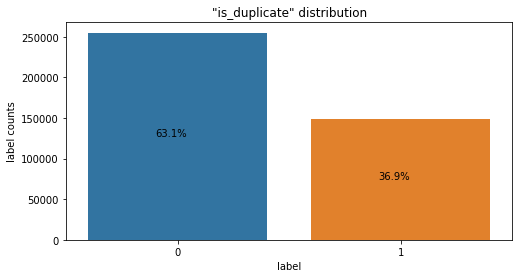

In [0]:
target_dist = RawDF['is_duplicate'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=target_dist.index,y=target_dist.values)
for x,y in zip(target_dist.index, target_dist.values):
    plt.text(x-0.1,y/2,"%.1f%%"%(y/len(RawDF)*100))
plt.title('"is_duplicate" distribution')
plt.xlabel('label')
plt.ylabel('label counts')
plt.savefig(FigurePath + '/01_target_dist.png',dpi=300)

### 3.2 Sentence Length Distribution

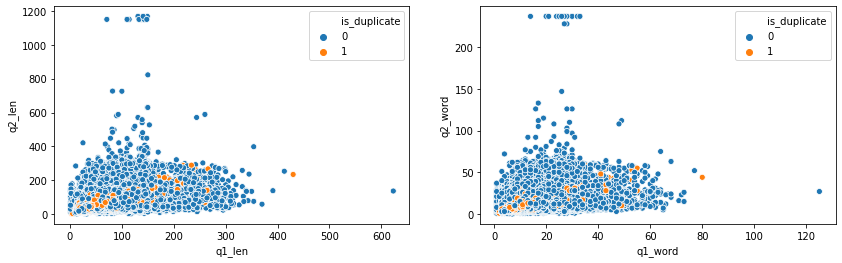

In [0]:
name = 'length_distribution'
lenDF = pd.DataFrame({})
lenDF['q1_len'] = RawDF['question1'].apply(lambda x: len(x))
lenDF['q2_len'] = RawDF['question2'].apply(lambda x: len(x))
lenDF['q1_word'] = RawDF['question1'].apply(lambda x: len(x.split()))
lenDF['q2_word'] = RawDF['question2'].apply(lambda x: len(x.split()))
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.scatterplot(x=lenDF['q1_len'],y=lenDF['q2_len'],hue=RawDF['is_duplicate'])
plt.subplot(122)
sns.scatterplot(x=lenDF['q1_word'],y=lenDF['q2_word'],hue=RawDF['is_duplicate'])
plt.savefig(FigurePath + '/02_'+name+'.png',dpi=300)

In [0]:
# 观察train不同句子长度的分布
display(lenDF['q1_word'].append(lenDF['q2_word']).describe(percentiles=[.5,.9,.99]))
print()

### 3.3 Sharing Words Distribution

In [0]:
# 对RawDF进行计算
shareSer = RawDF.apply(lambda x: len(set(x['question1'].split())&set(x['question2'].split())),axis=1)
TrainText =" ".join(RawDF['question1'].append(RawDF['question2']).values)
wordcloud = WordCloud(width=1080, height=720).generate(TrainText)

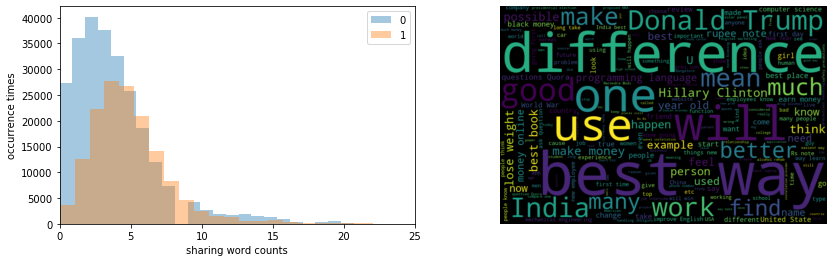

In [0]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(shareSer[RawDF['is_duplicate']==0],kde=False,label='0',bins=40)
sns.distplot(shareSer[RawDF['is_duplicate']==1],kde=False,label='1',bins=40)
plt.xlim([0,25])
plt.xlabel('sharing word counts')
plt.ylabel('occurrence times')
plt.legend()
plt.subplot(122)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(FigurePath + '/03_share_dist.png',dpi=300)

### 3.4 text occurrence frequency

What are the best ways to lose weight?                                                                                                                                                         161
How can you look at someone's private Instagram account without following them?                                                                                                                120
How can I lose weight quickly?                                                                                                                                                                 111
What's the easiest way to make money online?                                                                                                                                                    88
Can you see who views your Instagram?                                                                                                                                                           79
                         

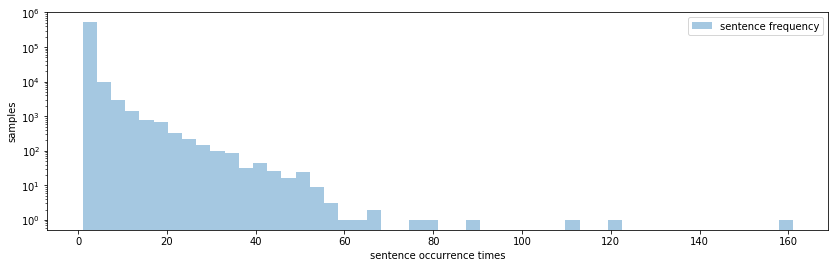

In [0]:
# 观察训练集句子长度的分布情况
q_freq = RawDF['question1'].append(RawDF['question2']).value_counts()
plt.figure(figsize=(14,4))
sns.distplot(q_freq,kde=False,label='sentence frequency')
plt.legend()
plt.yscale('log')
plt.xlabel('sentence occurrence times')
plt.ylabel('samples')
plt.savefig(FigurePath + '/04_occurrence_dist.png',dpi=300)
q_freq

## 2. Feature Engineering
* base_feature 
* fuzzy_feature
* BOW,tf-idf
* stat_feature

In [0]:
# 清理句子
from nltk.corpus import wordnet
nltk.download('wordnet')
def lem(word):
    # word = WNL.lemmatize(word,'n')
    word = WNL.lemmatize(word,'v')
    word = WNL.lemmatize(word,'r')
    word = WNL.lemmatize(word,'a')
    word = WNL.lemmatize(word,'s')
    return word
def clean_text(text):
    # text = re.sub('[^\x00-\x7F]+', ' ', text, flags=re.IGNORECASE)
    # 数字、序数
    text = re.sub("1'st", "1", text, flags=re.IGNORECASE)
    text = re.sub("1st", "1", text, flags=re.IGNORECASE)
    text = re.sub("2'nd", "2", text, flags=re.IGNORECASE)
    text = re.sub("2nd", "2", text, flags=re.IGNORECASE)
    text = re.sub("3'rd", "3", text, flags=re.IGNORECASE)
    text = re.sub("3rd", "3", text, flags=re.IGNORECASE)
    text = re.sub("([0-9]+)(th)", "\\1", text, flags=re.IGNORECASE)
    text = re.sub("\'th", "", text, flags=re.IGNORECASE)
    # 语法
    text = re.sub("\'s", " is ", text) 
    text = re.sub("\'ve", " have ", text, flags=re.IGNORECASE)
    text = re.sub("can't", " can not ", text, flags=re.IGNORECASE)
    text = re.sub("n't", " not ", text, flags=re.IGNORECASE)
    text = re.sub("i'm", " i am ", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text, flags=re.IGNORECASE)
    text = re.sub("\'d", " would ", text, flags=re.IGNORECASE)
    text = re.sub("\'ll", " will ", text, flags=re.IGNORECASE)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    # 符号
    text = re.sub('([\$\%\&\*\@\+\-\*\|\^\~])', r" \1 ", text, flags=re.IGNORECASE)
    # text = " ".join([i.lower() for i in text.split() if i.lower() not in StopWords])
    text = re.sub('[\:\;\?\!\,\.\/\"\']', " ", text, flags=re.IGNORECASE)     
    text = re.sub('[\(\)\{\}\[\]\<\>]', " ", text, flags=re.IGNORECASE)    # 括号
    # 去掉多余空格
    text = re.sub(" +", " ", text, flags=re.IGNORECASE)
    text = text.strip()
    # text = " ".join([lem(i.lower()) for i in text.split()])
    return text
def pos_tag(x):
    return " ".join([i for _,i in nltk.pos_tag(x.split())])

t1 = time.time()
train_clean = pd.DataFrame({})
test_clean = pd.DataFrame({})
print('<1> start clean data...')
train_clean['question1'] = RawDF['question1'].apply(lambda x: clean_text(x))
train_clean['question2'] = RawDF['question2'].apply(lambda x: clean_text(x))
test_clean['question1'] = TestDF['question1'].apply(lambda x: clean_text(x))
test_clean['question2'] = TestDF['question2'].apply(lambda x: clean_text(x))
print('<1> finish at ',datetime.datetime.now())
# 计算句子对的差异项
print('<2> start calculate difference word...')
train_clean['q1_diff'] = train_clean.apply(lambda x: " ".join(set(x['question1'].split())-set(x['question2'].split())),axis=1)
train_clean['q1_diff'] = train_clean['q1_diff'].replace("","*")
train_clean['q2_diff'] = train_clean.apply(lambda x: " ".join(set(x['question2'].split())-set(x['question1'].split())),axis=1)
train_clean['q2_diff'] = train_clean['q2_diff'].replace("","*")
train_clean['q1_diff_tag'] = train_clean['q1_diff'].apply(lambda x: pos_tag(x))
train_clean['q2_diff_tag'] = train_clean['q2_diff'].apply(lambda x: pos_tag(x))
test_clean['q1_diff'] = test_clean.apply(lambda x: " ".join(set(x['question1'].split())-set(x['question2'].split())),axis=1)
test_clean['q1_diff'] = test_clean['q1_diff'].replace("","*")
test_clean['q2_diff'] = test_clean.apply(lambda x: " ".join(set(x['question2'].split())-set(x['question1'].split())),axis=1)
test_clean['q2_diff'] = test_clean['q2_diff'].replace("","*")
test_clean['q1_diff_tag'] = test_clean['q1_diff'].apply(lambda x: pos_tag(x))
test_clean['q2_diff_tag'] = test_clean['q2_diff'].apply(lambda x: pos_tag(x))
print('<2> finish at ',datetime.datetime.now())
# 储存
print('saving...')
train_clean.to_pickle(datapath+'/train_clean.pkl')
test_clean.to_pickle(datapath+'/test_clean.pkl')
display(train_clean.head())
display(test_clean.head())
t2 = time.time()
print('finished, cost：%.1fmin'%((t2-t1)/60))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
<1> start clean data...


KeyboardInterrupt: ignored

In [0]:
# 若已clean，可从此处开始运行
train_clean = pd.read_pickle(datapath+'/train_clean.pkl')
test_clean = pd.read_pickle(datapath+'/test_clean.pkl')

In [0]:
# 载入embedding模型
model = FastText.load_fasttext_format(datapath+'/wiki.en.bin')

In [0]:
# data summary
S_train_s = set()
S_test_s = set()
S_train_w = set()
S_test_w = set()
for i,j in zip(train_clean['question1'],train_clean['question2']):
    S_train_s |= set([i])
    S_train_s |= set([j])
    S_train_w |= set(i.split())
    S_train_w |= set(j.split())
print('unique sentences in train_clean: ',len(S_train_s))
print('unique words in train_clean: ',len(S_train_w))
for i,j in zip(test_clean['question1'],test_clean['question2']):
    S_test_w |= set(i.split())
    S_test_w |= set(j.split())
    S_test_s |= set([i])
    S_test_s |= set([j])
print('unique sentences in test_clean: ',len(S_test_s))
print('unique words in test_clean: ',len(S_test_w))
tmp = pd.DataFrame({
        'Unique_sent':[len(S_train_s),len(S_test_s)],
        'Union_sent':[len(S_train_s|S_test_s),len(S_train_s|S_test_s)],
        'Intersection_sent':[len(S_train_s&S_test_s),len(S_train_s&S_test_s)],
        'Unique_word':[len(S_train_w),len(S_test_w)],
        'Union_word':[len(S_train_w|S_test_w),len(S_train_w|S_test_w)],
        'Intersection_word':[len(S_train_w&S_test_w),len(S_train_w&S_test_w)],
        'Pairs':[len(train_clean),len(test_clean)]
       },index=['train','test'])
display(tmp)
print('union sentence of train and test: ',len(S_train_s|S_test_s))
print('intersection sentence of train and test: ',len(S_train_s&S_test_s))
print('union words of train and test: ',len(S_train_w|S_test_w))
print('intersection words of train and test: ',len(S_train_w&S_test_w))

unique sentences in train_clean:  536375
unique words in train_clean:  113640
unique sentences in test_clean:  4360267
unique words in test_clean:  135584


,Unique_sent,Union_sent,Intersection_sent,Unique_word,Union_word,Intersection_word,Pairs
train,536375,4784495,112147,113640,176422,72802,404290
test,4360267,4784495,112147,135584,176422,72802,2345796


union sentence of train and test:  4784495
intersection sentence of train and test:  112147
union words of train and test:  176422
intersection words of train and test:  72802


In [0]:
# stat word intersection
word_dict = {}
QUESTION = train_clean[['question1','question2']].append(test_clean[['question1','question2']])
QUESTION_list = list(QUESTION['question1'].append(QUESTION['question2']))
for sent in TQ(QUESTION_list):
    for word in sent.split():
        try:
            word_dict[word] += 1
        except:
            word_dict[word] = 1
wordSer = pd.Series(word_dict)
wordSer

What           2025586
is             1680312
the            2341158
step              4805
by              108941
                ...   
sabine               1
azar                 1
byzantines           1
couponzguru          1
cdi                  1
Length: 176422, dtype: int64

In [0]:
wordSer[wordSer>125].sort_values()

Kinect             126
nazis              126
Fedora             126
notorious          126
initiatives        126
                ...   
a              1403305
I              1438166
is             1680312
What           2025586
the            2341158
Length: 17541, dtype: int64

In [0]:
wordSer.describe([0.5,0.75,0.8,0.85,0.9,0.95])

count    1.764220e+05
mean     3.521808e+02
std      1.297115e+04
min      1.000000e+00
50%      6.000000e+00
75%      2.300000e+01
80%      3.500000e+01
85%      6.000000e+01
90%      1.240000e+02
95%      3.830000e+02
max      2.341158e+06
dtype: float64

### 2.0 Magic Feature


In [0]:
# 统计两个句子的句频
QUESTION = RawDF[['question1','question2']].append(TestDF[['question1','question2']])
QUESTION_CNT = QUESTION['question1'].append(QUESTION['question2']).value_counts()
DICT = {}
print('<1>magic start at\t',datetime.datetime.now())
for i in range(len(QUESTION)):
    print('Process...%d/%d'%(i+1,len(QUESTION)),end='\r')
    try:
        DICT[QUESTION.iloc[i,0]].append(QUESTION.iloc[i,1])
    except:
        DICT[QUESTION.iloc[i,0]] = []
        DICT[QUESTION.iloc[i,0]].append(QUESTION.iloc[i,1])
    try:
        DICT[QUESTION.iloc[i,1]].append(QUESTION.iloc[i,0])
    except:
        DICT[QUESTION.iloc[i,1]] = []
        DICT[QUESTION.iloc[i,1]].append(QUESTION.iloc[i,0])
def calc_common_q(row):
    return len(set(DICT[row['question1']])&set(DICT[row['question2']]))
def calc_total_q(row):
    return len(set(DICT[row['question1']])|set(DICT[row['question2']]))
train_magic_feature = pd.DataFrame({})
test_magic_feature = pd.DataFrame({})
train_magic_feature['magic_min_freq'] = RawDF.apply(lambda x: min(QUESTION_CNT[x['question1']],QUESTION_CNT[x['question2']]),axis=1)
train_magic_feature['magic_max_freq'] = RawDF.apply(lambda x: max(QUESTION_CNT[x['question1']],QUESTION_CNT[x['question2']]),axis=1)
train_magic_feature['magic_common'] = RawDF.apply(calc_common_q,axis=1)
train_magic_feature['magic_total'] = RawDF.apply(calc_total_q,axis=1)
test_magic_feature['magic_min_freq'] = TestDF.apply(lambda x: min(QUESTION_CNT[x['question1']],QUESTION_CNT[x['question2']]),axis=1)
test_magic_feature['magic_max_freq'] = TestDF.apply(lambda x: max(QUESTION_CNT[x['question1']],QUESTION_CNT[x['question2']]),axis=1)
test_magic_feature['magic_common'] = TestDF.apply(calc_common_q,axis=1)
test_magic_feature['magic_total'] = TestDF.apply(calc_total_q,axis=1)
Stand = StandardScaler()
Stand.fit(train_magic_feature.append(test_magic_feature))
train_magic_feature = pd.DataFrame(Stand.transform(train_magic_feature),columns=train_magic_feature.keys())
test_magic_feature = pd.DataFrame(Stand.transform(test_magic_feature),columns=test_magic_feature.keys())
train_magic_feature.to_pickle(datapath+'/train_magic_feature.pkl')
test_magic_feature.to_pickle(datapath+'/test_magic_feature.pkl')
print('<1>magic end at\t',datetime.datetime.now())


<1>magic start at	 2019-11-22 12:54:43.369108
<1>magic end at	 2019-11-22 12:56:00.643153


### 2.1 Base_Feature
*using Raw data -- 2.9min*

In [0]:
# 计算基本统计特征
def base_feature(DF):
    df = pd.DataFrame({})
    # 句子总长度
    df['base_q1_len'] = DF['question1'].apply(lambda x: len(x))
    df['base_q2_len'] = DF['question2'].apply(lambda x: len(x))
    df['base_diff_len'] = (df['base_q1_len'] - df['base_q2_len']).abs()
    # 单词数量
    df['base_q1_word'] = DF['question1'].apply(lambda x: len(set(x.split())))
    df['base_q2_word'] = DF['question2'].apply(lambda x: len(set(x.split())))
    df['base_diff_word'] = (df['base_q1_word'] - df['base_q2_word']).abs()
    # 字符数量
    df['base_q1_char'] = DF['question1'].apply(lambda x: len(set(x.replace(" ",""))))
    df['base_q2_char'] = DF['question2'].apply(lambda x: len(set(x.replace(" ",""))))
    df['base_diff_char'] = (df['base_q1_char'] - df['base_q2_char']).abs()
    # 共有字符、共有词
    df['base_common_word'] = DF.apply(lambda x: len(set(x['question1'].split())&set(x['question2'].split())),axis=1)
    df['base_common_char'] = DF.apply(lambda x: len(set(x['question1'])&set(x['question1'])),axis=1)
    return df
t1 = time.time()
Stand = StandardScaler()
print('<1>extract base feature...')
train_base_feature = base_feature(RawDF)
test_base_feature = base_feature(TestDF)
Stand.fit(train_base_feature.append(test_base_feature))
train_base_feature = pd.DataFrame(Stand.transform(train_base_feature),columns=train_base_feature.keys())
train_base_feature.to_pickle(datapath+'/train_base_feature.pkl')
print('<2>train finished at\t',datetime.datetime.now())
test_base_feature = pd.DataFrame(Stand.fit_transform(test_base_feature),columns=test_base_feature.keys())
test_base_feature.to_pickle(datapath+'/test_base_feature.pkl')
print('<3>test finished at\t',datetime.datetime.now())
display(train_base_feature.describe([0.5,0.9,0.95,0.99]))
display(test_base_feature.describe([0.5,0.9,0.95,0.99]))
t2 = time.time()
print('process finished，cost：%.1fmin'%((t2-t1)/60))

<1>extract base feature...
<2>train finished at	 2019-11-22 13:12:33.779834
<3>test finished at	 2019-11-22 13:12:37.375021


,base_q1_len,base_q2_len,base_diff_len,base_q1_word,base_q2_word,base_diff_word,base_q1_char,base_q2_char,base_diff_char,base_common_word,base_common_char
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,-0.015995,0.002338,-0.118281,-0.010245,0.015798,-0.124737,-0.012676,-0.009593,-0.190636,0.361877,-0.012693
std,0.962260,1.050856,0.995246,0.945945,1.025725,0.969695,0.928221,0.946364,0.869491,1.126462,0.928309
min,-1.897303,-1.862931,-0.902445,-1.912044,-2.047996,-0.931075,-4.283281,-4.450737,-1.081224,-1.188517,-4.505060
50%,-0.258217,-0.280311,-0.435639,-0.311333,-0.309184,-0.435150,-0.062843,-0.055682,-0.470226,0.253246,-0.062819
90%,1.252313,1.333341,1.042580,1.289378,1.236427,1.052626,1.269927,1.262834,1.057268,1.695009,1.269853
95%,1.959370,2.109136,1.859490,1.889645,2.009232,1.796514,1.714183,1.702340,1.668265,2.415891,1.714077
99%,2.891399,3.412470,3.493311,3.090178,3.361642,3.532252,2.602696,2.801103,2.890260,4.578536,2.602525
max,18.093116,34.413208,41.110087,16.896308,26.159402,29.072404,7.045262,7.635663,10.222231,13.949997,7.044766


,base_q1_len,base_q2_len,base_diff_len,base_q1_word,base_q2_word,base_diff_word,base_q1_char,base_q2_char,base_diff_char,base_common_word,base_common_char
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,-7.469886e-16,3.641273e-16,-1.477479e-16,7.588536e-15,-4.379888e-16,2.003763e-15,-6.715834e-16,-1.376659e-15,1.350384e-15,8.762966e-15,-6.824908e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.920033e+00,-1.879498e+00,-9.233802e-01,-2.095015e+00,-2.054573e+00,-9.491885e-01,-4.454845e+00,-4.412908e+00,-1.095235e+00,-1.169527e+00,-4.674080e+00
50%,-2.273937e-01,-2.511434e-01,-3.395249e-01,-1.120000e-01,-3.078548e-01,-2.079437e-01,-6.426683e-02,-5.682719e-02,-1.942409e-01,-4.655308e-02,-6.424663e-02
90%,1.305563e+00,1.283267e+00,1.256346e+00,1.276110e+00,1.244783e+00,1.274546e+00,1.252907e+00,1.249997e+00,1.307416e+00,1.076421e+00,1.252849e+00
95%,2.040104e+00,2.066130e+00,2.034820e+00,2.069316e+00,2.021102e+00,2.015791e+00,1.691964e+00,1.685605e+00,1.908079e+00,1.825071e+00,1.691880e+00
99%,3.094012e+00,3.068194e+00,3.630691e+00,3.259125e+00,3.185581e+00,3.745362e+00,2.789609e+00,2.774625e+00,3.409736e+00,3.696695e+00,2.789459e+00
max,3.550965e+01,3.494636e+01,4.119205e+01,2.685700e+01,2.647515e+01,2.820644e+01,1.091218e+01,1.105118e+01,1.512266e+01,1.492644e+01,1.091155e+01


process finished，cost：3.2min


In [0]:
base_train.head()

,base_q1_len,base_q2_len,base_diff_len,base_q1_word,base_q2_word,base_diff_word,base_q1_char,base_q2_char,base_diff_char,base_common_word,base_common_char,base_q1_freq,base_q2_freq
id,,,,,,,,,,,,,
100599,84,65,19,15,11,4,23,23,0,6,24,1,1
276982,19,111,92,4,19,15,12,30,18,1,13,1,1
268145,70,71,1,14,13,1,22,20,2,6,23,1,1
25966,59,57,2,10,11,1,18,20,2,0,19,1,1
55916,84,110,26,14,19,5,26,26,0,1,27,1,1


### 2.2 Fuzzy_Feature
*using Raw data -- 427min*

In [0]:
# 计算模糊距离
def fuzzy_feature(DF):
    df = pd.DataFrame({})
    q1 = 'question1'
    q2 = 'question2'
    print('<1>start fuzzying at\t',datetime.datetime.now())
    df['Qratio'] = DF.apply(lambda x:fuzz.QRatio(x[q1],x[q2]),axis=1)
    print('<2>Qratio finished at\t',datetime.datetime.now())
    df['Wratio'] = DF.apply(lambda x:fuzz.WRatio(x[q1],x[q2]),axis=1)
    print('<3>Wratio finished at\t',datetime.datetime.now())
    df['fuzz_ratio'] = DF.apply(lambda x:fuzz.ratio(x[q1],x[q2]),axis=1)
    print('<4>fuzz finished at\t',datetime.datetime.now())
    df['partial_ratio'] = DF.apply(lambda x:fuzz.partial_ratio(x[q1],x[q2]),axis=1)
    print('<5>Pratio finished at\t',datetime.datetime.now())
    df['set_ratio'] = DF.apply(lambda x:fuzz.token_set_ratio(x[q1],x[q2]),axis=1)
    print('<6>set_ratio finished at\t',datetime.datetime.now())
    df['partial_set_ratio'] = DF.apply(lambda x:fuzz.partial_token_set_ratio(x[q1],x[q2]),axis=1)
    print('<7>Pset ratio finished at\t',datetime.datetime.now())
    df['sort_ratio'] = DF.apply(lambda x:fuzz.token_sort_ratio(x[q1],x[q2]),axis=1)
    print('<8>sort_ratio finished at\t',datetime.datetime.now())
    df['partial_sort_ratio'] = DF.apply(lambda x:fuzz.partial_token_sort_ratio(x[q1],x[q2]),axis=1)
    print('<9>Psort_ratio finished at\t',datetime.datetime.now())
    return df
t1 = time.time()
Stand = StandardScaler()
train_fuzz_feature = fuzzy_feature(RawDF)
test_fuzz_feature = fuzzy_feature(TestDF)
Stand.fit(train_fuzz_feature.append(test_fuzz_feature))
train_fuzz_feature = pd.DataFrame(Stand.transform(train_fuzz_feature),columns=train_fuzz_feature.keys())
train_fuzz_feature.to_pickle(datapath+'/train_fuzz_feature.pkl')
print('****************')
test_fuzz_feature = pd.DataFrame(Stand.transform(test_fuzz_feature),columns=test_fuzz_feature.keys())
test_fuzz_feature.to_pickle(datapath+'/test_fuzz_feature.pkl')
display(train_fuzz_feature.describe([0.5,0.9,0.99]))
display(test_fuzz_feature.describe([0.5,0.9,0.99]))
t2 = time.time()
print('转换完成，耗时：%.1fmin'%((t2-t1)/60))

<1>start fuzzying at	 2019-11-12 23:01:01.975539
<2>Qratio finished at	 2019-11-12 23:03:06.944584
<3>Wratio finished at	 2019-11-12 23:18:59.472562
<4>fuzz finished at	 2019-11-12 23:20:44.934275
<5>Pratio finished at	 2019-11-12 23:32:56.215300
<6>set_ratio finished at	 2019-11-12 23:35:48.997402
<7>Pset ratio finished at	 2019-11-12 23:48:19.861855
<8>sort_ratio finished at	 2019-11-12 23:50:26.102890
<9>Psort_ratio finished at	 2019-11-13 00:04:09.048985
<1>start fuzzying at	 2019-11-13 00:04:09.051406
<2>Qratio finished at	 2019-11-13 00:16:14.513149
<3>Wratio finished at	 2019-11-13 02:03:08.051733
<4>fuzz finished at	 2019-11-13 02:13:56.210823
<5>Pratio finished at	 2019-11-13 03:33:36.263043
<6>set_ratio finished at	 2019-11-13 03:50:37.059865
<7>Pset ratio finished at	 2019-11-13 05:12:40.601682
<8>sort_ratio finished at	 2019-11-13 05:25:33.318982
<9>Psort_ratio finished at	 2019-11-13 06:54:27.039454
****************


,Qratio,Wratio,fuzz_ratio,partial_ratio,set_ratio,partial_set_ratio,sort_ratio,partial_sort_ratio
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.463625,0.306067,0.460596,0.451185,0.468746,0.129517,0.511391,0.478653
std,1.127421,0.910421,1.129794,1.120828,1.006785,0.755749,1.091950,1.108805
min,-2.538829,-3.727653,-2.526242,-3.284540,-3.025333,-5.718221,-3.044478,-3.891607
50%,0.493054,0.761483,0.463138,0.447329,0.639484,0.283165,0.502537,0.489108
90%,2.034690,1.189020,2.009369,1.987465,1.665632,0.283165,1.989995,2.015721
99%,2.445793,1.456230,2.473238,2.520589,1.861089,0.283165,2.562094,2.745840
max,2.599957,1.616557,2.627861,2.639061,1.861089,0.283165,2.676514,2.745840


,Qratio,Wratio,fuzz_ratio,partial_ratio,set_ratio,partial_set_ratio,sort_ratio,partial_sort_ratio
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,-7.990425e-02,-5.274965e-02,-7.938211e-02,-7.776017e-02,-8.078681e-02,-2.232183e-02,-8.813656e-02,-8.249429e-02
std,9.538613e-01,1.005270e+00,9.536739e-01,9.564023e-01,9.763500e-01,1.034660e+00,9.560381e-01,9.561196e-01
min,-2.538829e+00,-3.727653e+00,-2.526242e+00,-3.284540e+00,-3.025333e+00,-5.718221e+00,-3.044478e+00,-3.891607e+00
50%,-1.749878e-01,2.270622e-01,-1.553543e-01,-1.450313e-01,-4.461539e-02,2.831648e-01,-6.956255e-02,-1.082623e-01
90%,1.212484e+00,8.683673e-01,1.236253e+00,1.217397e+00,1.176990e+00,2.831648e-01,1.131846e+00,1.219227e+00
99%,2.137466e+00,1.242462e+00,2.112451e+00,2.165173e+00,1.861089e+00,2.831648e-01,2.104414e+00,2.148470e+00
max,2.599957e+00,1.616557e+00,2.627861e+00,2.639061e+00,1.861089e+00,2.831648e-01,2.676514e+00,2.745840e+00


转换完成，耗时：473.5min


### 2.3 Sentiment_Feature
*using Clean data -- 86min*

In [0]:
def sentiment_feature(DF):
    df = pd.DataFrame({})
    df['q1_polarity'] = DF['question1'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['q2_polarity'] = DF['question2'].apply(lambda x: TextBlob(x).sentiment.polarity)
    print('polarity finished at\t', datetime.datetime.now())
    df['q1_subject'] = DF['question1'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['q2_subject'] = DF['question2'].apply(lambda x: TextBlob(x).sentiment.subjectivity) 
    print('subject finished at\t', datetime.datetime.now())
    df['q1_q2_polarity'] = (df['q1_polarity'] - df['q2_polarity']).abs()
    df['q1_q2_subject'] = (df['q1_subject'] - df['q2_subject']).abs()
    return df
t1 = time.time()
Stand = StandardScaler()
print('start sentiment at\t', datetime.datetime.now())
train_sentiment = sentiment_feature(train_clean)
test_sentiment = sentiment_feature(test_clean)
Stand.fit(train_sentiment.append(test_sentiment))
train_sentiment = pd.DataFrame(Stand.transform(train_sentiment),columns=train_sentiment.keys())
train_sentiment.to_pickle(datapath+'/train_sentiment.pkl')
print('end train at\t', datetime.datetime.now())
print('********************')
test_sentiment = pd.DataFrame(Stand.transform(test_sentiment),columns=test_sentiment.keys())
test_sentiment.to_pickle(datapath+'/test_sentiment.pkl')
print('end test at\t', datetime.datetime.now())
display(train_sentiment.describe())
display(test_sentiment.describe())
t2 = time.time()
print('process finished, cost：%.1fmin'%((t2-t1)/60))

start sentiment at	 2019-11-13 07:16:39.488302
polarity finished at	 2019-11-13 07:23:30.855949
subject finished at	 2019-11-13 07:30:20.893558
polarity finished at	 2019-11-13 08:10:09.234340
subject finished at	 2019-11-13 08:49:58.214385
end train at	 2019-11-13 08:49:59.675377
********************
end test at	 2019-11-13 08:50:00.577368


,q1_polarity,q2_polarity,q1_subject,q2_subject,q1_q2_polarity,q1_q2_subject
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.030426,0.043478,-0.000538,0.006245,-0.146492,-0.160844
std,1.026637,1.033641,0.993917,0.993654,0.920834,0.943358
min,-3.518932,-3.504113,-0.873779,-0.877152,-0.713544,-0.816457
25%,-0.389209,-0.395469,-0.873779,-0.877152,-0.713544,-0.816457
50%,-0.389209,-0.395469,-0.311622,-0.202511,-0.713544,-0.816457
75%,0.332127,0.381692,0.812691,0.809450,0.178907,0.306115
max,2.740514,2.713175,2.499160,2.496052,6.426064,2.925451


,q1_polarity,q2_polarity,q1_subject,q2_subject,q1_q2_polarity,q1_q2_subject
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,-5.243766e-03,-7.493221e-03,9.276415e-05,-1.076263e-03,2.524739e-02,2.772094e-02
std,9.952436e-01,9.938954e-01,1.001045e+00,1.001086e+00,1.010877e+00,1.006849e+00
min,-3.518932e+00,-3.504113e+00,-8.737787e-01,-8.771522e-01,-7.135436e-01,-8.164572e-01
25%,-3.892086e-01,-3.954692e-01,-8.737787e-01,-8.771522e-01,-7.135436e-01,-8.164572e-01
50%,-3.892086e-01,-3.954692e-01,-3.678379e-01,-3.711715e-01,-4.701479e-01,-3.954926e-01
75%,2.367360e-01,2.262597e-01,8.126906e-01,8.094501e-01,4.763910e-01,6.803060e-01
max,2.740514e+00,2.713175e+00,2.499160e+00,2.496052e+00,6.426064e+00,2.925451e+00


process finished, cost：93.4min


### 2.4 Embedding_Feature
*using Clean data -- 170min*

In [0]:
train_clean.head(3)

,question1,question2,q1_diff,q2_diff,q1_diff_tag,q2_diff_tag
id,,,,,,
171136,would you press a button that kill a random pe...,would you push a button for one million dollar...,1 $ press no ever your that kill give crime ab...,for in world dollars push when die the it,CD $ NN DT RB PRP$ IN VB VB NN IN CC,IN IN NN NNS VBP WRB VBP DT PRP
129860,what be the best lawyer joke,what be your favorite lawyer joke,the best,your favorite,DT JJS,PRP$ JJ
47799,how can i die without any pain,what be the simple way to die without pain,can how i any,to be way the what simple,MD WRB VB DT,TO VB NN DT WP NN


#### 2.4.1 Word Mover Distance

In [0]:
# word mover distance
def wmd_df(train_clean,test_clean):
    train_wmd = pd.DataFrame({})
    test_wmd = pd.DataFrame({})
    Stand = StandardScaler()
    print('start calc wmd at\t',datetime.datetime.now())
    train_wmd['wmd_q1_q2'] = train_clean.iloc[:].apply(lambda x: model.wv.wmdistance(x['question1'].split(),x['question2'].split()),axis=1).copy()
    train_wmd['wmd_diff'] = train_clean.iloc[:].apply(lambda x: model.wv.wmdistance(x['q1_diff'].split(),x['q2_diff'].split()),axis=1).copy()
    print('train finished at\t',datetime.datetime.now())
    test_wmd['wmd_q1_q2'] = test_clean.iloc[:].apply(lambda x: model.wv.wmdistance(x['question1'].split(),x['question2'].split()),axis=1).copy()
    test_wmd['wmd_diff'] = test_clean.iloc[:].apply(lambda x: model.wv.wmdistance(x['q1_diff'].split(),x['q2_diff'].split()),axis=1).copy()
    for item in ['wmd_q1_q2','wmd_diff']:
    train_wmd[item].fillna(train_wmd[item].max()*2)
    test_wmd[item].fillna(train_wmd[item].max()*2)
    Stand.fit(train_wmd.append(test_wmd))
    train_wmd = pd.DataFrame(Stand.transform(train_wmd),columns=train_wmd.keys())
    train_wmd.to_pickle(datapath+'/train_wmd.pkl')
    test_wmd = pd.DataFrame(Stand.transform(test_wmd),columns=test_wmd.keys())
    test_wmd.to_pickle(datapath+'/test_wmd.pkl')
    print('test finished at\t',datetime.datetime.now())
    return train_wmd, test_wmd
train_wmd, test_wmd = wmd_df(train_clean.iloc[:,:],test_clean.iloc[:,:])
display(train_wmd.describe())
display(test_wmd.describe())

start calc wmd at	 2019-11-13 22:57:56.319060
train finished at	 2019-11-13 23:20:28.994510


#### 2.4.2 Question Embedding

In [0]:
def Embedding_feature(train_clean, test_clean, embedding='fasttext', pad=30):
    t1 = time.time()
    print('<1>start embedding at\t',datetime.datetime.now())
    tk = Tokenizer(nb_words=200000)
    train_feature = pd.DataFrame({})
    test_feature = pd.DataFrame({})
    ## 转换data为token,并padding
    tk.fit_on_texts(train_clean['question1'].append(train_clean['question2']).append(test_clean['question1']).append(test_clean['question2']).values)
    for s in ['question1','question2']:
        tmp = tk.texts_to_sequences(train_clean[s])
        train_feature[s] = list(pad_sequences(tmp,maxlen=pad))
        tmp = tk.texts_to_sequences(test_clean[s])
        test_feature[s] = list(pad_sequences(tmp,maxlen=pad))
    train_feature.to_pickle(datapath+'/train_embedding.pkl')
    test_feature.to_pickle(datapath+'/test_embedding.pkl')
    print('<2>end embedding at\t',datetime.datetime.now())
    embedding_matrix = np.random.randn(len(tk.word_index)+1,300)         # 嵌入维度为300
    null_list = []                                # 保存未存在词汇表中的词
    for word,index in tk.word_index.items():
        try: 
            embedding_matrix[index,:] = model[word]
        except:
            null_list.append(word)
    print('<3>total word:\t%d, extra word:\t%d(%.2f)'%(len(tk.word_index),len(null_list),len(null_list)/len(tk.word_index)))
    with open(datapath+'/null_list.txt','w') as f:
        for i in null_list:
            f.write(i+'\n')
    np.savetxt(ModelPath + '/embedding_matrix_'+str(embedding)+'.txt', embedding_matrix, fmt='%0.8f')
    t2 = time.time()
    print('<4>embedding finished, cost：%.1fmin'%((t2-t1)/60))
    return train_feature,test_feature,embedding_matrix

train_feature,test_feature,embedding_matrix = Embedding_feature(train_clean, test_clean, 'fasttext', pad=30)

#### 2.4.3 Distance Fearure

In [0]:
train_embedding = pd.read_pickle(datapath+'/train_embedding.pkl')        # 30列(300)
test_embedding = pd.read_pickle(datapath+'/test_embedding.pkl')        # 30列(300)
embedding_matrix = np.loadtxt(ModelPath+'/embedding_matrix_fasttext.txt')

,question1,question2
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [0]:

def sent2vec(sent):
    vec = np.zeros((300,))
    cnt = 0.01
    for word in sent:
        try:
            vec += embedding_matrix[word]
            cnt += 1
        except: continue
    vec = vec / cnt 
    return vec 
def calc_distance(row):
    Dict = pd.Series()
    Q1 = row[0]
    Q2 = row[1]
    Dict['Euclidean_emb'] = euclidean(Q1,Q2)
    Dict['Cityblock_emb'] = cityblock(Q1,Q2)
    Dict['Chebyshev_emb'] = chebyshev(Q1,Q2)
    Dict['Cosine_emb'] = cosine(Q1,Q2)
    Dict['Canberra_emb'] = canberra(Q1,Q2)
    Dict['Braycurtis_emb'] = braycurtis(Q1,Q2)
    Dict['Minkowski_emb'] = minkowski(Q1,Q2,3)
    Dict['q1_skew_emb'] = skew(Q1)
    Dict['q2_skew_emb'] = skew(Q2)
    Dict['q1_kur_emb'] = kurtosis(Q1)
    Dict['q2_kur_emb'] = kurtosis(Q2)
    return Dict
print('<1>start distance calc at\t',datetime.datetime.now())
Stand = StandardScaler()
tmpDF = pd.DataFrame({})
train_dist_emb = pd.DataFrame({})
test_dist_emb = pd.DataFrame({})
tmpDF['q1_vec'] = train_embedding['question1'].iloc[:].apply(lambda x: sent2vec(x))
tmpDF['q2_vec'] = train_embedding['question2'].iloc[:].apply(lambda x: sent2vec(x))
tmpDF.to_pickle(datapath+'/train_vec_emb.pkl')
train_dist_emb = tmpDF.apply(lambda x: calc_distance(x),axis=1)
print('<2>end train distance at\t',datetime.datetime.now())
tmpDF = pd.DataFrame({})
tmpDF['q1_vec'] = test_embedding['question1'].iloc[:].apply(lambda x: sent2vec(x))
tmpDF['q2_vec'] = test_embedding['question2'].iloc[:].apply(lambda x: sent2vec(x))
tmpDF.to_pickle(datapath+'/test_vec_emb.pkl')
test_dist_emb = tmpDF.apply(lambda x: calc_distance(x),axis=1)
for item in train_dist_emb.keys():
    train_dist_emb[item].fillna(train_dist_emb[item].max()*10)
    test_dist_emb[item].fillna(test_dist_emb[item].max()*10)

Stand.fit(train_dist_emb.append(test_dist_emb))
train_dist_emb = pd.DataFrame(Stand.transform(train_dist_emb),columns=train_dist_emb.keys())
train_dist_emb.to_pickle(datapath+'/train_dist_emb.pkl')
test_dist_emb = pd.DataFrame(Stand.transform(test_dist_emb),columns=test_dist_emb.keys())
test_dist_emb.to_pickle(datapath+'/test_dist_emb.pkl')
print('<3>end test distance at \t',datetime.datetime.now())
test_dist_emb.describe()

<1>start distance calc at	 2019-11-24 02:02:58.953378
<2>end train distance at	 2019-11-24 03:27:08.285433
<3>end test distance at 	 2019-11-24 11:41:52.075737


,Euclidean_emb,Cityblock_emb,Chebyshev_emb,Cosine_emb,Canberra_emb,Braycurtis_emb,Minkowski_emb,q1_skew_emb,q2_skew_emb,q1_kur_emb,q2_kur_emb
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,2.176024e-02,2.173734e-02,2.178978e-02,7.679988e-04,1.659574e-02,1.332523e-02,2.176722e-02,6.998456e-04,-1.139852e-03,2.134656e-04,-4.665399e-03
std,1.006155e+00,1.006174e+00,1.006093e+00,9.990069e-01,1.001209e+00,1.002258e+00,1.006151e+00,1.011260e+00,9.949202e-01,1.015034e+00,9.856946e-01
min,-9.792566e-01,-9.779760e-01,-9.858333e-01,-1.742569e-01,-9.095133e-01,-7.307685e-01,-9.797738e-01,-3.116185e+01,-2.966044e+01,-1.425817e+01,-1.428801e+01
25%,-7.021716e-01,-7.019146e-01,-6.947848e-01,-1.713474e-01,-5.837989e-01,-5.612712e-01,-7.021384e-01,-3.124075e-01,-3.037069e-01,-2.612914e-01,-2.546665e-01
50%,-2.975128e-01,-2.975758e-01,-3.079052e-01,-1.678888e-01,-3.546825e-01,-3.438090e-01,-2.976658e-01,-3.765178e-02,-4.181345e-02,1.087140e-03,-8.098367e-03
75%,3.655523e-01,3.647578e-01,3.380455e-01,-1.535442e-01,1.565586e-01,9.993700e-02,3.652507e-01,2.779583e-01,2.608551e-01,2.213730e-01,1.987846e-01
max,6.668639e+00,6.682455e+00,7.385588e+00,1.106760e+01,5.076084e+00,5.958594e+00,6.695987e+00,2.836669e+01,2.804872e+01,4.395951e+01,3.583779e+01


#### 2.4.4 Tag_Vec

In [0]:
print('<1>start tag calc at\t',datetime.datetime.now())
SVD = TruncatedSVD(n_components=100,random_state=1024)
Stand = StandardScaler()
train_tag1 = train_clean['q1_diff_tag'].iloc[:100].apply(lambda x: sent2vec(x))
train_tag2 = train_clean['q2_diff_tag'].iloc[:100].apply(lambda x: sent2vec(x))
tag11 = np.zeros((train_length,300))
tag12 = np.zeros((train_length,300))
for i in range(train_length):
    tag11[i,:] = train_tag1.iloc[i]
    tag12[i,:] = train_tag2.iloc[i]
print('<2>end train calc at\t',datetime.datetime.now())
test_tag1 = test_clean['q1_diff_tag'].iloc[:100].apply(lambda x: sent2vec(x))
test_tag2 = test_clean['q2_diff_tag'].iloc[:100].apply(lambda x: sent2vec(x))
tag21 = np.zeros((test_length,300))
tag22 = np.zeros((test_length,300))
for i in range(test_length):
    tag21[i,:] = test_tag1.iloc[i]
    tag22[i,:] = test_tag2.iloc[i]
SVD.fit(np.vstack((tag11+tag12),(tag21+tag22)))
Stand.fit(np.vstack((SVD.transform(tag11+tag12)),SVD.transform(tag21+tag22)))
train_tag_vec_emb = pd.DataFrame(Stand.transform(SVD.transform(tag1+tag2))).astype('float32')
train_tag_vec_emb.to_pickle(datapath+'/train_tag_vec_emb.pkl')
test_tag_vec_emb = pd.DataFrame(Stand.transform(SVD.transform(tag1+tag2))).astype('float32')
test_tag_vec_emb.to_pickle(datapath+'/test_tag_vec_emb.pkl')
print('<3>end test calc at\t',datetime.datetime.now())
train_tag_vec_emb.describe()

<1>start tag calc at	 2019-11-09 09:14:56.719181
<2>end train calc at	 2019-11-09 09:14:58.309266
<3>end test calc at	 2019-11-09 09:14:59.675689


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,...,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,2.000332e-08,-2.225637e-08,2.624989e-08,-7.984042e-09,-3.423691e-08,-2.589822e-09,-2.231598e-08,4.301071e-08,3.919601e-08,2.384186e-09,3.883839e-08,9.524822e-09,-1.239777e-09,-2.920628e-08,-6.604195e-09,-6.175041e-09,-3.576279e-09,-2.050400e-08,-1.196861e-08,-3.843456e-08,9.894371e-10,1.218542e-08,1.088381e-08,2.310276e-08,1.618564e-08,-1.978874e-08,2.428293e-08,2.007186e-08,7.346272e-10,1.509786e-08,4.249811e-09,1.962185e-08,-1.011044e-08,-1.908839e-08,4.618708e-09,3.936775e-08,1.885742e-09,-2.013333e-08,-5.459786e-09,1.466274e-09,...,3.710985e-08,2.578497e-08,3.147125e-09,2.124310e-08,-1.349449e-08,9.015203e-09,-4.632473e-08,-1.125336e-08,1.161396e-08,-2.427101e-08,-8.440018e-09,-1.415014e-08,-1.034737e-08,3.904700e-08,-3.037453e-08,1.308918e-08,2.121925e-09,-1.354515e-09,-2.932548e-09,4.053116e-09,-1.204014e-08,1.425743e-08,-1.940727e-08,2.443791e-09,-5.722046e-10,1.878738e-08,-1.391172e-08,1.588464e-09,1.251698e-08,1.788139e-08,9.346008e-09,-4.649162e-09,1.239777e-09,-1.535863e-08,1.020432e-08,7.510185e-10,2.328754e-08,-2.486110e-08,-5.197525e-09,-2.398491e-08
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000102e+00,1.000100e+00,1.000098e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000101e+00,1.000100e+00,1.000099e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000099e+00,1.000101e+00,1.000099e+00,1.000100e+00,1.000099e+00,1.000098e+00,1.000099e+00,1.000100e+00,1.000099e+00,1.000097e+00,1.000098e+00,1.000099e+00,1.000099e+00,1.000100e+00,1.000099e+00,1.000100e+00,1.000098e+00,1.000101e+00,1.000094e+00,1.000098e+00,1.000099e+00,1.000098e+00,1.000091e+00,1.000099e+00,1.000099e+00,...,1.000101e+00,1.000100e+00,1.000099e+00,1.000098e+00,1.000100e+00,1.000101e+00,1.000100e+00,1.000100e+00,1.000101e+00,1.000100e+00,1.000099e+00,1.000100e+00,1.000100e+00,1.000099e+00,1.000100e+00,1.000098e+00,1.000100e+00,1.000100e+00,1.000099e+00,1.000099e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000099e+00,1.000099e+00,1.000102e+00,1.000099e+00,1.000100e+00,1.000100e+00,1.000101e+00,1.000102e+00,1.000100e+00,1.000101e+00,1.000099e+00,1.000098e+00,1.000098e+00,1.000102e+00,1.000102e+00,1.000100e+00
min,-2.037546e+00,-1.996609e+00,-8.833769e-01,-5.893061e+00,-5.113060e+00,-2.329774e+00,-4.755819e+00,-4.859728e+00,-5.023461e+00,-5.965631e+00,-4.385844e+00,-5.098096e+00,-3.265770e+00,-5.786840e+00,-7.987813e+00,-4.135865e+00,-4.386832e+00,-3.695919e+00,-3.106121e+00,-9.335426e+00,-3.800149e+00,-1.035184e+01,-7.783948e+00,-1.106421e+01,-6.920637e+00,-7.875187e+00,-1.082785e+01,-5.790669e+00,-8.583033e+00,-1.491540e+01,-1.031963e+01,-1.466004e+01,-9.992390e+00,-1.513250e+00,-2.189675e+00,-2.449161e-01,-1.405487e+01,-7.315377e-01,-1.171193e+01,-1.111437e+01,...,-7.714471e+00

### 2.5 Bag_of_Words_Feature
*using Clean data*

In [0]:
train_clean.head(3)

,question1,question2,q1_diff,q2_diff,q1_diff_tag,q2_diff_tag
id,,,,,,
171136,would you press a button that kill a random pe...,would you push a button for one million dollar...,1 $ press no ever your that kill give crime ab...,for in world dollars push when die the it,CD $ NN DT RB PRP$ IN VB VB NN IN CC,IN IN NN NNS VBP WRB VBP DT PRP
129860,what be the best lawyer joke,what be your favorite lawyer joke,the best,your favorite,DT JJS,PRP$ JJ
47799,how can i die without any pain,what be the simple way to die without pain,can how i any,to be way the what simple,MD WRB VB DT,TO VB NN DT WP NN


#### 2.5.1 Question Diff Vector

In [0]:
# process bag of words
print('<1>start question vector BoW...')
CNT = CountVectorizer(stop_words=None,ngram_range=(1,1),analyzer='word',min_df=10,max_df=1000,max_features=50000)
SVD = TruncatedSVD(n_components=100,random_state=1024)
Stand = StandardScaler()
CNT.fit(train_clean['question1'].append(train_clean['question2']).append(test_clean['question1']).append(test_clean['question2']))
SVD.fit(CNT.transform(train_clean['question1'].append(train_clean['question2']).append(test_clean['question1']).append(test_clean['question2'])))
print('<2>end train CNT&SVD at\t',datetime.datetime.now())
train_diff = train_clean['q1_diff']+" "+train_clean['q2_diff']
bow1 = CNT.transform(train_diff)
bow1 = SVD.transform(bow1)
print('<3>end train BoW at\t',datetime.datetime.now())
test_diff = test_clean['q1_diff']+" "+test_clean['q2_diff']
bow2 = CNT.transform(test_diff)
bow2 = SVD.transform(bow2)
Stand.fit(np.vstack((bow1,bow2)))
train_bow = pd.DataFrame(Stand.transform(bow1)).astype('float32')
train_bow.to_pickle(datapath+'/train_diff_vec_bow.pkl')
test_bow = pd.DataFrame(Stand.transform(bow2)).astype('float32')
test_bow.to_pickle(datapath+'/test_diff_vec_bow.pkl')
print('<4>end test BoW at\t',datetime.datetime.now())
display(train_bow.describe())
display(test_bow.describe())

<1>start question vector BoW...
<2>end train CNT&SVD at	 2019-11-23 02:26:47.708069
<3>end train BoW at	 2019-11-23 02:26:51.725336
<4>end test BoW at	 2019-11-23 02:27:46.172370


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,...,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.000364,-0.006520,-0.005611,-0.002132,0.004937,-0.011705,-0.009392,-0.004965,-0.000503,-0.002748,-0.011753,-0.003802,-0.009722,-0.005504,-0.004287,-0.007878,-0.012189,0.001177,-0.010876,-0.009237,-0.001566,-0.007390,-0.000323,-0.012076,0.026943,-0.016884,0.002478,-0.033853,0.031420,-0.006445,0.020955,-0.020823,0.020262,-0.026881,-0.022688,-0.009162,-0.012531,-0.016828,0.011097,0.009475,...,0.015525,-0.006335,0.007117,-0.009579,-0.006308,0.012508,-0.002404,0.015968,-0.012579,-0.003779,0.002004,0.009970,-0.018647,-0.003778,0.001334,0.002267,-0.005832,0.001326,-0.008749,0.008767,0.000419,0.003712,-0.000164,0.004189,-0.008548,0.002225,-0.003789,-0.000346,0.000735,0.003059,-0.001829,0.004859,0.002973,-0.001013,-0.006311,0.003012,0.007022,0.001148,-0.005746,-0.000511
std,1.071153,0.799861,0.873966,0.945595,1.323644,0.557015,0.752070,1.050835,1.214886,0.995851,0.765847,0.975503,0.768140,0.874284,1.000418,1.075714,0.867066,0.847535,0.873229,0.952130,0.971318,0.824946,0.853995,1.086437,0.855254,1.398091,0.871642,1.772301,1.477404,1.171608,1.299308,0.910909,0.939740,0.935647,0.882677,0.880909,0.903156,0.923669,0.892677,1.079878,...,0.929886,0.896406,0.885452,0.863367,0.875408,0.917620,0.877592,0.903648,0.878811,0.905025,0.871805,0.901046,0.878268,0.896177,0.899942,0.883385,0.888054,0.889055,0.881345,0.910222,0.885194,0.876539,0.889434,0.884654,0.883411,0.900923,0.893340,0.879349,0.895552,0.899691,0.891977,0.898384,0.900547,0.896715,0.895982,0.907441,0.904487,0.885437,0.893042,0.895981
min,-0.024027,-0.141312,-3.604666,-0.754189,-0.620411,-1.589683,-3.161119,-5.291387,-18.153078,-5.113670,-7.732813,-7.922591,-8.743338,-26.520754,-21.969852,-18.074705,-22.419075,-38.729992,-18.750050,-33.440872,-98.764755,-73.279739,-84.193260,-33.512405,-81.366623,-121.915436,-37.722572,-109.205055,-59.761280,-26.941326,-63.408741,-48.373241,-88.432602,-54.098709,-72.847748,-59.536964,-24.455465,-65.500114,-47.866306,-31.325018,...,-36.554531,-19.096172,-29.978184,-34.379333,-35.792801,-33.249969,-23.678366,-34.023773,-25.329157,-19.596481,-30.122599,-21.525072,-28.032246,-35.879936,-23.485451,-23.392397,-27.857439,-28.772434,-19.770433,-22.344950,-26.361967,-22.685839,-27.616238,-22.108627,-28.483986,-20.088503,-27.780539,-28.071129,-22.161003,-25.518011,-22.844500,-19.168427,-20.433638,-15.592152,-15.202250,-19.159292,-22.133976,-24.576241,-16.220236,-18.527708
25%,-0.005190,-0.022499,-0.020405,-0.021459,-0.024384,-0.020874,-0.024632,-0.039056,-0.037066,-0.019650,-0.035931,-0.033442,-0.048680,-0.049275,-0.047277,-0.079108,-0.037001,-0.023732,-0.066755,-0.048899,-0.041557,-0.008536,0.026092,0.002019,0.062795,

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,...,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,-6.491494e-05,1.133833e-03,9.565833e-04,3.615674e-04,-8.616769e-04,2.016965e-03,1.609113e-03,8.532455e-04,8.753125e-05,4.747371e-04,2.024783e-03,6.533056e-04,1.689694e-03,9.405000e-04,7.429857e-04,1.360266e-03,2.073533e-03,-2.047643e-04,1.886825e-03,1.602274e-03,2.781273e-04,1.277402e-03,5.710064e-05,2.090379e-03,-4.629009e-03,2.878970e-03,-4.281247e-04,5.818486e-03,-5.384894e-03,1.115291e-03,-3.626644e-03,3.583004e-03,-3.467624e-03,4.641849e-03,3.902802e-03,1.572538e-03,2.163890e-03,2.868747e-03,-1.896492e-03,-1.628613e-03,...,-2.689879e-03,1.075030e-03,-1.224966e-03,1.678554e-03,1.106949e-03,-2.172379e-03,4.240807e-04,-2.725221e-03,2.151587e-03,6.563067e-04,-3.441254e-04,-1.710097e-03,3.215395e-03,6.514585e-04,-2.314308e-04,-3.913730e-04,1.000881e-03,-2.272552e-04,1.512578e-03,-1.522994e-03,-7.274427e-05,-6.408039e-04,3.581158e-05,-7.171994e-04,1.462636e-03,-3.792736e-04,6.518404e-04,5.713298e-05,-1.244166e-04,-5.248720e-04,3.148208e-04,-8.385655e-04,-5.185070e-04,1.729851e-04,1.083793e-03,-5.167225e-04,-1.205287e-03,-1.990642e-04,9.953751e-04,8.771661e-05
std,9.871947e-01,1.030261e+00,1.019733e+00,1.008515e+00,9.323025e-01,1.056932e+00,1.035739e+00,9.896452e-01,9.567696e-01,9.997301e-01,1.033616e+00,1.002875e+00,1.033009e+00,1.018332e+00,9.982522e-01,9.837081e-01,1.019685e+00,1.022734e+00,1.017890e+00,1.006243e+00,1.003307e+00,1.026088e+00,1.021674e+00,9.833491e-01,1.019446e+00,9.123077e-01,1.019459e+00,7.931006e-01,8.910905e-01,9.630874e-01,9.374511e-01,1.008357e+00,1.006705e+00,1.006655e+00,1.016407e+00,1.017627e+00,1.013402e+00,1.009630e+00,1.015715e+00,9.843450e-01,...,1.009736e+00,1.014545e+00,1.017330e+00,1.020028e+00,1.018863e+00,1.011740e+00,1.018494e+00,1.013652e+00,1.017843e+00,1.014158e+00,1.018548e+00,1.014375e+00,1.018018e+00,1.015652e+00,1.014678e+00,1.017089e+00,1.017031e+00,1.016652e+00,1.017872e+00,1.013071e+00,1.017436e+00,1.018551e+00,1.016574e+00,1.017502e+00,1.017317e+00,1.015028e+00,1.016225e+00,1.018186e+00,1.015880e+00,1.014955e+00,1.016406e+00,1.014784e+00,1.015166e+00,1.015592e+00,1.015785e+00,1.014096e+00,1.013975e+00,1.017416e+00,1.016208e+00,1.015754e+00
min,-2.302594e-02,-1.334290e-01,-4.614434e+00,-9.653215e-01,-6.158392e-01,-2.069434e+00,-2.827468e+00,-5.308605e+00,-1.797803e+01,-4.794497e+00,-8.243802e+00,-6.802852e+00,-8.746766e+00,-2.602612e+01,-2.613939e+01,-1.924545e+01,-2.922596e+01,-4.895508e+01,-1.899243e+01,-3.416177e+01,-7.830561e+01,-8.825172e+01,-5.334849e+01,-4.053635e+01,-8.108820e+01,-1.207392e+02,-3.737955e+01,-1.051971e+02,-5.579801e+01,-5.322937e+01,-6.040052e+01,-8.237404e+01,-7.621635e+01,-4.890093e+01,-6.830195e+01,-5.111469e+01,-2.670674e+01,-6.063599e+01,-4.881827e+01,-4.300449e+01,...,-5.044078e+01,-2.50

#### 2.5.2 Diff Tag Vector

In [0]:
print('<1>start bag of words process...')
CNT = CountVectorizer(stop_words=None,ngram_range=(1,1),analyzer='word',min_df=1,max_features=10000)
Stand = StandardScaler()
bow1 = train_clean['q1_diff_tag']+" "+train_clean['q2_diff_tag']
print('<2>end train tag at\t',datetime.datetime.now())
bow2 = test_clean['q1_diff_tag']+" "+test_clean['q2_diff_tag']
CNT.fit(bow1.append(bow2))
Stand.fit(np.vstack((CNT.transform(bow1).toarray(),CNT.transform(bow2).toarray())))
train_diff_tag = pd.DataFrame(Stand.transform(CNT.transform(bow1).toarray()))
train_diff_tag.to_pickle(datapath+'/train_tag_vec_bow.pkl')
test_diff_tag = pd.DataFrame(Stand.transform(CNT.transform(bow2).toarray()))
test_diff_tag.to_pickle(datapath+'/test_tag_vec_bow.pkl')
print('<3>end test tag at\t',datetime.datetime.now())
train_diff_tag.describe()


<1>start bag of words process...
<2>end train tag at	 2019-11-23 02:28:11.745053
<3>end test tag at	 2019-11-23 02:29:45.845311


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,-0.050472,-0.070264,-0.092158,-0.013896,-0.011531,-0.107136,-0.182086,-0.032090,-0.063532,-0.002808,-0.033286,-0.221852,-0.116499,-0.009708,-0.125224,-0.005952,-0.002007,-0.083297,-0.070096,-0.029043,-0.026295,-0.027684,-0.011032,-0.027709,-0.005415,-0.093118,-0.068182,-0.062530,-0.038684,-0.130227,-0.115282,-0.012448,-0.160524,-0.112101
std,0.971012,0.907114,0.986039,0.963448,0.894334,0.993379,0.957089,0.920426,0.918000,0.914729,0.996559,0.967435,0.964841,0.955596,0.957121,0.912567,0.882683,0.985496,0.964662,0.901368,0.891085,0.909615,0.880125,0.982547,0.889807,0.967184,0.951733,0.960414,0.972875,0.955443,0.968138,0.972773,0.938432,0.950555
min,-0.553190,-0.381080,-0.956876,-0.182255,-0.061531,-1.016077,-0.863518,-0.183180,-0.339197,-0.017196,-0.615050,-1.254556,-0.738565,-0.103434,-0.814827,-0.036919,-0.009086,-0.785137,-0.576849,-0.150624,-0.125251,-0.157325,-0.049003,-0.561764,-0.025987,-0.769895,-0.429512,-0.485661,-0.408045,-0.812479,-0.804056,-0.214336,-0.720486,-0.625937
25%,-0.553190,-0.381080,-0.956876,-0.182255,-0.061531,-1.016077,-0.863518,-0.183180,-0.339197,-0.017196,-0.615050,-0.747445,-0.738565,-0.103434,-0.814827,-0.036919,-0.009086,-0.785137,-0.576849,-0.150624,-0.125251,-0.157325,-0.049003,-0.561764,-0.025987,-0.769895,-0.429512,-0.485661,-0.408045,-0.812479,-0.804056,-0.214336,-0.720486,-0.625937
50%,-0.553190,-0.381080,0.187231,-0.182255,-0.061531,-0.241710,-0.863518,-0.183180,-0.339197,-0.017196,-0.615050,-0.240333,-0.738565,-0.103434,-0.814827,-0.036919,-0.009086,-0.785137,-0.576849,-0.150624,-0.125251,-0.157325,-0.049003,-0.561764,-0.025987,-0.769895,-0.429512,-0.485661,-0.408045,-0.812479,-0.804056,-0.214336,-0.720486,-0.625937
75%,-0.553190,-0.381080,0.187231,-0.182255,-0.061531,0.532656,-0.018951,-0.183180,-0.339197,-0.017196,1.142099,0.266778,0.460517,-0.103434,0.204155,-0.036919,-0.009086,0.223046,0.667661,-0.150624,-0.125251,-0.157325,-0.049003,-0.561764,-0.025987,0.304783,-0.429512,-0.485661,-0.408045,0.367734,0.595341,-0.214336,1.100897,1.057984
max,8.726006,20.928890,7.051875,11.099029,60.415736,9.050686,13.494132,20.364835,11.597000,58.151867,9.927845,10.916113,14.849506,67.426625,12.431936,26.886751,110.063238,10.304878,14.357267,19.521463,15.877536,24.786165,40.401713,4.102041,38.480221,12.126243,22.175667,15.483892,12.260192,10.989650,8.991719,13.841309,6.565049,7.793667


### 2.6 TF-IDF Feature

#### 2.6.1 Question Vector

In [0]:
print('<1>start tfidf process at',datetime.datetime.now())
TFIDF = TfidfVectorizer(stop_words=None,ngram_range=(1,1),analyzer='word',min_df=10,max_features=50000) 
SVD = TruncatedSVD(n_components=30,random_state=1024)
TFIDF.fit(train_clean['question1'].append(train_clean['question2']).append(test_clean['question1']).append(test_clean['question2']))
SVD.fit(TFIDF.transform(train_clean['question1'].append(train_clean['question2']).append(test_clean['question1']).append(test_clean['question2'])))
print('<2>end fitting at\t',datetime.datetime.now())
Q1 = TFIDF.transform(train_clean['question1'])
Q1_train = pd.DataFrame(SVD.transform(Q1)).astype('float32')
Q1_train.to_pickle(datapath+'/train_q1v_tfidf.pkl')
print('<3>end train q1 at\t',datetime.datetime.now())
Q2 = TFIDF.transform(train_clean['question2'])
Q2_train = pd.DataFrame(SVD.transform(Q2)).astype('float32')
Q2_train.to_pickle(datapath+'/train_q2v_tfidf.pkl')
print('<4>end train q2 at\t',datetime.datetime.now())
Q1 = TFIDF.transform(test_clean['question1'])
Q1_test = pd.DataFrame(SVD.transform(Q1)).astype('float32')
Q1_test.to_pickle(datapath+'/test_q1v_tfidf.pkl')
print('<5>end test q1 at\t',datetime.datetime.now())
Q2 = TFIDF.transform(test_clean['question2'])
Q2_test = pd.DataFrame(SVD.transform(Q2)).astype('float32')
Q2_test.to_pickle(datapath+'/test_q2v_tfidf.pkl')
print('<6>end test q2 at\t',datetime.datetime.now())

<1>start tfidf process at 2019-11-23 02:30:26.875907
<2>end fitting at	 2019-11-23 02:34:19.599676
<3>end train q1 at	 2019-11-23 02:34:25.393287
<4>end train q2 at	 2019-11-23 02:34:31.483240
<5>end test q1 at	 2019-11-23 02:35:08.813117
<6>end test q2 at	 2019-11-23 02:35:39.479367


#### 2.6.2 Distance Feature


In [0]:
# load data
Q1_train =pd.read_pickle(datapath+'/train_q1v_tfidf.pkl').iloc[:,:]
Q2_train =pd.read_pickle(datapath+'/train_q2v_tfidf.pkl').iloc[:,:]
Q1_test =pd.read_pickle(datapath+'/test_q1v_tfidf.pkl').iloc[:,:]
Q2_test =pd.read_pickle(datapath+'/test_q2v_tfidf.pkl').iloc[:,:]

In [0]:
# calc distance by scipy
def calc_distance(row):
    Dict = pd.Series()
    Q1 = row['q1_vec']
    Q2 = row['q2_vec']
    Dict['Euclidean_tf'] = euclidean(Q1,Q2)
    Dict['Cityblock_tf'] = cityblock(Q1,Q2)
    Dict['Chebyshev_tf'] = chebyshev(Q1,Q2)
    Dict['Cosine_tf'] = cosine(Q1,Q2)
    Dict['Canberra_tf'] = canberra(Q1,Q2)
    Dict['Braycurtis_tf'] = braycurtis(Q1,Q2)
    Dict['Minkowski_tf'] = minkowski(Q1,Q2,3)
    Dict['q1_skew_tf'] = skew(Q1)
    Dict['q2_skew_tf'] = skew(Q2)
    Dict['q1_kur_tf'] = kurtosis(Q1)
    Dict['q2_kur_tf'] = kurtosis(Q2)
    return Dict
train_dist_tfidf = pd.DataFrame({})
test_dist_tfidf = pd.DataFrame({})
print('<1>start tfidf at\t',datetime.datetime.now())
tmp = pd.DataFrame({})
Stand = StandardScaler()
tmp['q1_vec'] = list(Q1_train.values)
tmp['q2_vec'] = list(Q2_train.values)
train_dist_tfidf = tmp.apply(lambda x: calc_distance(x),axis=1)
print('<2>end train dist at\t',datetime.datetime.now())
tmp = pd.DataFrame({})
tmp['q1_vec'] = list(Q1_test.values)
tmp['q2_vec'] = list(Q2_test.values)
test_dist_tfidf = tmp.apply(lambda x: calc_distance(x),axis=1)
Stand.fit(train_dist_tfidf.append(test_dist_tfidf))
train_dist_tfidf = pd.DataFrame(Stand.transform(train_dist_tfidf),columns=train_dist_tfidf.keys())
train_dist_tfidf.to_pickle(datapath+'/train_dist_tfidf.pkl')
test_dist_tfidf = pd.DataFrame(Stand.transform(test_dist_tfidf),columns=test_dist_tfidf.keys())
test_dist_tfidf.to_pickle(datapath+'/test_dist_tfidf.pkl')
print('<3>end test dist at\t',datetime.datetime.now())
display(train_dist_tfidf.describe())
display(test_dist_tfidf.describe())

<1>start tfidf at	 2019-11-23 02:37:18.906745


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


<2>end train dist at	 2019-11-23 03:44:45.867264


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1178: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


<3>end test dist at	 2019-11-23 10:14:44.616297


,Euclidean_tf,Cityblock_tf,Chebyshev_tf,Cosine_tf,Canberra_tf,Braycurtis_tf,Minkowski_tf,q1_skew_tf,q2_skew_tf,q1_kur_tf,q2_kur_tf
count,404290.000000,404290.000000,404290.000000,404252.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,-0.206686,-0.215671,-0.161805,-0.302978,-0.365538,-0.335559,-0.195039,0.032489,0.024526,0.029272,0.020751
std,1.045229,1.046516,1.025450,1.026051,1.238081,1.077663,1.041313,1.002036,0.993516,1.024539,1.011984
min,-2.350541,-2.323834,-2.100740,-1.787708,-3.706054,-2.380556,-2.318574,-4.427705,-4.149488,-2.410376,-2.433166
25%,-0.831445,-0.869818,-0.779953,-1.181175,-0.902845,-1.126264,-0.810507,-0.656506,-0.659266,-0.713384,-0.714528
50%,-0.165247,-0.178510,-0.201284,-0.389211,-0.062800,-0.329824,-0.164340,-0.061884,-0.063766,-0.257333,-0.255824
75%,0.456541,0.462244,0.410250,0.525064,0.525255,0.515794,0.448666,0.668938,0.660266,0.463519,0.461995
max,7.581977,7.991324,10.187060,2.591298,2.424651,3.111963,8.492479,5.209437,5.300001,7.764205,8.027281


,Euclidean_tf,Cityblock_tf,Chebyshev_tf,Cosine_tf,Canberra_tf,Braycurtis_tf,Minkowski_tf,q1_skew_tf,q2_skew_tf,q1_kur_tf,q2_kur_tf
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345426e+06,2.345796e+06,2.345795e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,3.562155e-02,3.717016e-02,2.788647e-02,5.222062e-02,6.299923e-02,5.783240e-02,3.361425e-02,-5.599378e-03,-4.227040e-03,-5.044995e-03,-3.576332e-03
std,9.876371e-01,9.870138e-01,9.928883e-01,9.860807e-01,9.387063e-01,9.743925e-01,9.888278e-01,9.995425e-01,1.001053e+00,9.956232e-01,9.978769e-01
min,-2.350541e+00,-2.323834e+00,-2.100740e+00,-1.787708e+00,-3.706054e+00,-2.380556e+00,-2.318574e+00,-5.157652e+00,-6.261664e+00,-2.410376e+00,-2.433166e+00
25%,-5.544973e-01,-5.719522e-01,-5.762699e-01,-7.450746e-01,-3.651447e-01,-6.431603e-01,-5.512713e-01,-6.933281e-01,-6.942482e-01,-7.169651e-01,-7.177628e-01
50%,-4.287349e-03,-1.617219e-03,-8.348192e-02,9.052417e-02,2.633877e-01,1.269251e-01,-1.859423e-02,-8.574089e-02,-8.192400e-02,-2.853226e-01,-2.824760e-01
75%,5.657089e-01,5.888482e-01,4.973634e-01,8.937929e-01,7.084866e-01,8.476599e-01,5.463616e-01,6.323281e-01,6.385552e-01,4.243208e-01,4.312733e-01
max,7.707935e+00,8.197902e+00,1.286701e+01,2.961951e+00,2.424651e+00,3.704568e+00,9.884908e+00,5.243184e+00,5.670650e+00,8.071815e+00,8.678409e+00


## 4. Modeling Implementation


### 4.1 Data Preparation


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 导入基础包
!pip install gensim
!pip install fuzzywuzzy
!pip install textblob
from fuzzywuzzy import fuzz
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, os, re, sys, datetime, nltk, random
from nltk.stem import WordNetLemmatizer     # 导入词性还原函数
from tqdm import tqdm_notebook as TQ
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import KeyedVectors
from scipy.spatial.distance import euclidean,cityblock,chebyshev,jaccard,cosine,canberra,braycurtis,minkowski
from scipy.stats import skew, kurtosis
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import keras.backend as K
from sklearn.preprocessing import StandardScaler 
from gensim.models.fasttext import FastText
from keras.layers import Input,Dense,Conv1D,LSTM,GRU,add,subtract,multiply,dot,concatenate,Flatten,Lambda,MaxPooling1D
from keras.layers import BatchNormalization,Dropout,Embedding,Bidirectional,TimeDistributed,Activation,Flatten,Reshape
from keras.layers import MaxPooling2D, Conv2D, GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.models import load_model
from keras.optimizers import Nadam, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras import regularizers, Model
from keras.utils import plot_model
random.seed(1)
# 建立文件夹
try:
    os.makedirs('/content/drive/My Drive/figure')
    os.makedirs('/content/drive/My Drive/model')
    os.makedirs('/content/drive/My Drive/data')
except: pass
# 设置数据路径
FigurePath = r'/content/drive/My Drive/figure'
ModelPath = r'/content/drive/My Drive/model'
datapath = r'/content/drive/My Drive/data'
SavePath = datapath + '/PreTrain.csv'           # 储存预处理后的数据
TestSavePath =  datapath + '/PreTest.csv'
TrainPath = datapath + '/train.csv'
TestPath = datapath + '/test.csv'
NA_DF_Path = datapath + '/NA_id.csv'
ProTrain = datapath + '/ProTrain.csv'
ProTest = datapath + '/ProTest.csv'
filename = datapath + '/GoogleNews-vectors-negative300.bin'     #　google pre-trained word2vec
# 数据增强
def load_data():
    RawDF = pd.read_csv(TrainPath,keep_default_na=False).astype('object')
    TestDF = pd.read_csv(TestPath,encoding='utf-8',index_col='test_id',keep_default_na=False)
    RawDF = RawDF.set_index('id')                             # 设置id为索引
    RawDF.drop(columns=['qid1','qid2'],inplace=True)                    # 去掉qid列
    return RawDF,TestDF
nltk.download('stopwords')
StopWords = stopwords.words("english") 
WNL = WordNetLemmatizer()
pad=35 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# 绘制训练曲线
def plot_fit(h,name="figure",saving=True):
    if not name==None: print(str(name)+":")
    acc, val_acc = h.history['acc'], h.history['val_acc']
    loss, val_loss = h.history['loss'], h.history['val_loss']
    epochs = range(1,len(acc)+1)
    f = plt.figure(figsize=(14,5))
    f.suptitle(str(name))
    plt.subplot(121)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(epochs,acc)
    plt.plot(epochs,val_acc,'r')
    plt.legend(['train','val'])
    plt.subplot(122)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs,loss,'--',)
    plt.plot(epochs,val_loss,'r--')
    plt.legend(['train','val'])
    plt.savefig(FigurePath + '/%s.png'%(name),dpi=300)
    if saving:
        resultDF = pd.DataFrame({
            'acc':acc,
            'val_acc':val_acc,
            'loss':loss,
            'val_loss':val_loss})
        resultDF.to_csv(ModelPath + '/%s.csv'%(name))

In [0]:
# load train feature
train_magic_feature = pd.read_pickle(datapath+'/train_magic_feature.pkl')
test_magic_feature = pd.read_pickle(datapath+'/test_magic_feature.pkl')
Stand = StandardScaler()
Stand.fit(train_magic_feature.append(test_magic_feature))
train_magic_feature = pd.DataFrame(Stand.transform(train_magic_feature),columns=train_magic_feature.keys())
test_magic_feature = pd.DataFrame(Stand.transform(test_magic_feature),columns=test_magic_feature.keys())
train_base_feature = pd.read_pickle(datapath+'/train_base_feature.pkl')     # 13列
train_fuzz_feature = pd.read_pickle(datapath+'/train_fuzz_feature.pkl')     # 8列
train_sentiment = pd.read_pickle(datapath+'/train_sentiment.pkl')        # 6列
# train_wmd = pd.read_pickle(datapath+'/train_wmd.pkl')              # 2列
train_embedding = pd.read_pickle(datapath+'/train_embedding.pkl')        # 30列(300)
embedding_matrix = np.loadtxt(ModelPath+'/embedding_matrix_fasttext.txt')
train_dist_emb = pd.read_pickle(datapath+'/train_dist_emb.pkl')         # 11列
# train_tag_vec_emb = pd.read_pickle(datapath+'/train_tag_vec_emb.pkl')      # 100列
train_diff_vec_bow = pd.read_pickle(datapath+'/train_diff_vec_bow.pkl')     # 100列
train_tag_vec_bow = pd.read_pickle(datapath+'/train_tag_vec_bow.pkl')      # 33列
train_q1v_tfidf = pd.read_pickle(datapath+'/train_q1v_tfidf.pkl')        # 100列
train_q2v_tfidf = pd.read_pickle(datapath+'/train_q2v_tfidf.pkl')        # 100列
train_dist_tfidf = pd.read_pickle(datapath+'/train_dist_tfidf.pkl')       # 11列
RawDF, TestDF = load_data()
train_length = len(RawDF)
test_length = len(TestDF)
train_Y = RawDF['is_duplicate'].iloc[:].copy()
try:
    train_base_feature.drop(columns=['base_q1_len','base_q2_len','base_q1_word','base_q2_word','base_q1_char','base_q2_char'],inplace=True)
except: pass
try:
    train_sentiment['diff_polarity'] = train_sentiment.apply(lambda x: abs(x['q1_polarity']-x['q2_polarity']),axis=1)
    train_sentiment['diff_subject'] = train_sentiment.apply(lambda x: abs(x['q1_subject']-x['q2_subject']),axis=1)
    train_sentiment.drop(columns=['q1_polarity','q2_polarity','q1_subject','q2_subject'],inplace=True)
except: pass
try:
    train_diff_tfidf = (train_q1v_tfidf-train_q2v_tfidf).abs()
except: pass
try:
    train_dist_tfidf['skew_diff_tf'] = (train_dist_tfidf['q1_skew_tf'] - train_dist_tfidf['q2_skew_tf']).abs()
    train_dist_tfidf['kur_diff_tf'] = (train_dist_tfidf['q1_kur_tf'] - train_dist_tfidf['q2_kur_tf']).abs()
    train_dist_tfidf.drop(columns=['q1_skew_tf','q2_skew_tf','q1_kur_tf','q2_kur_tf'],inplace=True)
except: pass


In [0]:
pd.concat([train_magic_feature,train_base_feature,train_fuzz_feature,train_sentiment,train_dist_tfidf],axis=1)

,magic_min_freq,magic_max_freq,magic_common,magic_total,base_diff_len,base_diff_word,base_diff_char,base_common_word,base_common_char,Qratio,Wratio,fuzz_ratio,partial_ratio,set_ratio,partial_set_ratio,sort_ratio,partial_sort_ratio,q1_q2_polarity,q1_q2_subject,diff_polarity,diff_subject,Euclidean_tf,Cityblock_tf,Chebyshev_tf,Cosine_tf,Canberra_tf,Braycurtis_tf,Minkowski_tf,skew_diff_tf,kur_diff_tf
0,-0.116140,-0.065960,-0.114782,-0.066839,-0.552340,-0.683112,-1.081224,2.415891,-0.062819,2.240242,1.349346,2.267074,2.520589,1.861089,0.283165,2.276044,1.949346,-0.713544,-0.816457,0.006261,0.003374,-1.018910,-0.945471,-0.959543,-1.276906,-0.273625,-0.883132,-1.041684,1.951324,3.367376
1,0.210311,-0.008624,-0.114782,0.009909,0.536874,0.060776,1.362766,0.253246,0.159293,0.852769,0.868367,0.823925,1.039689,1.176990,0.283165,0.559747,0.953729,-0.713544,-0.816457,0.006261,0.003374,-0.934695,-0.815168,-0.985837,-0.094372,0.934299,0.269885,-0.977900,1.257412,3.554078
2,-0.116140,-0.065960,-0.114782,-0.066839,-0.357838,0.060776,-0.775725,-0.107195,1.047741,-0.329151,-0.521127,-0.206895,-0.855863,0.053113,0.283165,0.559747,0.820980,-0.713544,-0.816457,0.006261,0.003374,-0.290331,-0.104967,-0.893458,-0.181779,0.580179,0.240510,-0.443883,0.293003,0.905913
3,-0.116140,-0.075516,-0.114782,-0.076432,-0.318937,-0.683112,1.057268,-1.188517,-0.284931,-2.076339,-2.284716,-2.165454,-2.099820,-1.657135,-3.797778,-1.671440,-1.900373,-0.249469,2.588679,0.400603,3.072748,-0.191444,-0.189423,0.102883,0.793145,0.697185,0.640582,-0.160331,1.359981,2.387651
4,-0.116140,-0.056404,-0.114782,-0.057245,0.536874,0.556701,1.057268,-0.467635,1.047741,-0.740254,0.868367,-0.619224,-0.085795,0.248570,0.283165,-0.355612,0.555482,-0.713544,-0.816457,0.006261,0.003374,-1.358731,-1.385060,-1.200362,-1.248574,-0.729761,-1.245513,-1.315123,0.790652,0.484232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,0.210311,-0.056404,-0.114782,-0.038059,-0.669042,-0.683112,-1.081224,2.055450,0.825629,2.137466,1.189020,1.957828,1.691285,1.714497,0.283165,1.989995,1.617474,-0.713544,-0.816457,0.008368,0.003227,-1.011388,-1.218421,-0.348764,-1.330820,-1.890118,-1.565095,-0.811280,0.844233,0.903685
404286,2.169015,0.058269,2.952944,0.067469,-0.863544,-0.683112,0.140771,0.613687,-0.729155,1.161096,0.280504,1.184712,1.217397,0.834941,0.283165,0.903006,0.754606,0.535888,1.615783,1.081765,2.189209,0.770664,0.776721,0.519425,-0.462892,-0.484512,-0.605173,0.755990,0.404441,0.580015
404287,-0.116140,-0.075516,-0.114782,-0.076432,-0.902445,-0.683112,-1.081224,-0.828076,-2.061827,1.315260,0.280504,1.390877,1.217397,0.639484,0.283165,1.246266,1.086478,-0.713544,-0.816457,0.006261,0.003374,-1.798245,-1.793499,-1.631410,-1.656796,-1.756479,-1.844938,-1.771124,0.275283,0.376153
404288,-0.116140,-0.075516,-0.114782,-0.076432,0.381272,0.556701,-0.775725,-0.828076,1.269853,-0.997194,-1.857179,-0.980011,-1.270515,-1.217357,0.283165,-1.042131,-1.502126,0.442586,-0.816457,1.015912,0.003240,0.087921,0.229113,-0.038820,0.853390,0.849957,1.171213,-0.030645,0.039623,0.442916


In [0]:
# 实际是1但错分为0：单复数、符号多余
nltk.download('wordnet')
WNL = WordNetLemmatizer()
q1 = 'question1'
q2 = 'question2'
train_clean = pd.read_pickle(datapath+'/train_clean.pkl')
test_clean = pd.read_pickle(datapath+'/test_clean.pkl')
maybe_1 = train_clean[(train_fuzz_feature['fuzz_ratio']>0)&(RawDF['is_duplicate']==0)].copy()
Q1 = maybe_1[q1]
Q2 = maybe_1[q2]
# list(maybe_1[Q1==Q2].index)
RawDF.loc[list(maybe_1[Q1.str.lower()==Q2.str.lower()].index),:]
print((train_Y==1).sum()/len(train_Y))
train_Y[maybe_1[Q1.str.lower()==Q2.str.lower()].index] = 1
print((train_Y==1).sum()/len(train_Y))
# maybe_1[Q1==Q2].to_csv(datapath+'/wrong1_1.csv')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
0.369197853026293
0.3693709960671795


In [0]:
# data preparation
print('start prepare data at\t',datetime.datetime.now())
Q1 = np.zeros((train_length, pad))
Q2 = np.zeros((train_length, pad))
for i in range(train_length):
    Q1[i,:] = train_embedding['question1'].loc[i]
    Q2[i,:] = train_embedding['question2'].loc[i]
dist_feat = pd.concat([train_dist_tfidf,train_dist_emb],axis=1)
base_feat = pd.concat([train_magic_feature,train_base_feature,train_fuzz_feature,train_sentiment],axis=1)
tag_feat = pd.concat([train_tag_vec_bow],axis=1)
vec_feat = pd.concat([train_diff_vec_bow,train_diff_tfidf],axis=1)
# fill NA
for col in dist_feat.keys():
    dist_feat[col].fillna(2*dist_feat[col].max(),inplace=True)
# for col in base_feat.keys():
#   base_feat[col].fillna(10*base_feat[col].max(),inplace=True)
print('prepare data finished at\t',datetime.datetime.now())


start prepare data at	 2019-12-02 23:16:53.256368
prepare data finished at	 2019-12-02 23:17:23.279281


In [0]:
# split data
pt = 0.1753
train_weight = 0.95
val_weight = 1 - train_weight
seed = 2019
Y1 = train_Y[train_Y==1]
Y0 = train_Y[train_Y==0]
ind1_val = Y1.sample(int(val_weight*len(train_Y)*pt)).index
ind0_val = Y0.sample(int(val_weight*len(train_Y)*(1-pt))).index
print(len(ind1_val)/(len(ind0_val)+len(ind1_val)),(len(ind0_val)+len(ind1_val))/len(train_Y))
ind1_train = Y1.drop(index=ind1_val).index
ind0_train = Y0.drop(index=ind0_val).index
ind_train = list(ind1_train)+list(ind0_train)
ind_val  = list(ind1_val)+list(ind0_val)
Q1_train = Q1[ind_train]
Q1_val = Q1[ind_val]
Q2_train = Q2[ind_train]
Q2_val = Q2[ind_val]
dist_feat_train = dist_feat.loc[ind_train,:]
dist_feat_val = dist_feat.loc[ind_val,:]
base_feat_train = base_feat.loc[ind_train,:]
base_feat_val = base_feat.loc[ind_val,:]
tag_feat_train = tag_feat.loc[ind_train,:]
tag_feat_val = tag_feat.loc[ind_val,:]
vec_feat_train = vec_feat.loc[ind_train,:]
vec_feat_val = vec_feat.loc[ind_val,:]
Y_train = train_Y[ind_train]
Y_val = train_Y[ind_val]
print('finished data split at\t',datetime.datetime.now())
print(dist_feat.shape,base_feat.shape,tag_feat.shape,vec_feat.shape,Q1.shape,Q2.shape,train_Y.shape)

0.17528323356255876 0.049996289791981
finished data split at	 2019-12-02 23:17:28.082234
(404290, 20) (404290, 17) (404290, 34) (404290, 130) (404290, 35) (404290, 35) (404290,)


In [0]:
# double data
# Q1 = np.vstack((Q1t,Q2t))
# Q2 = np.vstack((Q2t,Q1t))
# dist_feat = dist_feat.append(dist_feat,ignore_index=True)
# base_feat = base_feat.append(base_feat,ignore_index=True)
# tag_feat = tag_feat.append(tag_feat,ignore_index=True)
# vec_feat = vec_feat.append(vec_feat,ignore_index=True)
# train_Y = train_Y.append(train_Y,ignore_index=True)
# print('data double finished at\t',datetime.datetime.now())

In [0]:
# class_weight
p1 = len(ind1_train)/len(ind_train)
p0 = 1 - p1
weight1 = pt / p1
weight0 = (1-pt) / p0
class_weight = {0: weight0, 1: weight1}
print(class_weight)

{0: 1.329272272092057, 1: 0.4618197276905138}


### 4.2 Logistic Regression (base without embedding)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 21)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 130)          0                                     

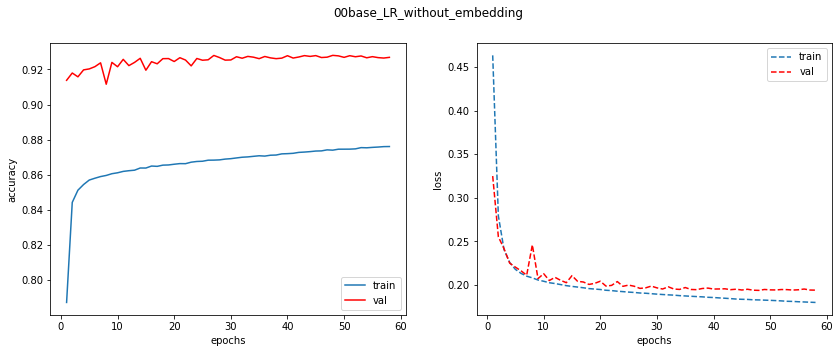

In [0]:
# baseline
model_name = '00base_LR_without_embedding'
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,checkpoint,early]
def base_model(embedding_matrix):
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge = concatenate([DIST,BASE,TAG,VEC])
    Merge = BatchNormalization()(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v0 = base_model(embedding_matrix)
plot_model(model_v0,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h0 = model_v0.fit([dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
          batch_size=2048, epochs=200, shuffle=True,
          validation_data=([dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          # validation_split=0.05,
          class_weight=class_weight,callbacks=callback)
plot_fit(h0,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

### 4.2 Logistic Regression (base)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      37947300    input_5[0][0]                    
                                                                 input_6[0][0]                    
____________________________________________________________________________

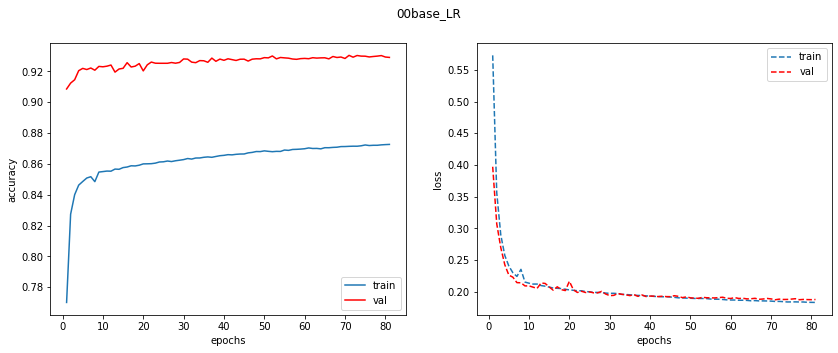

In [0]:
# baseline
model_name = '00base_LR'
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
Logfile = TensorBoard(log_dir=ModelPath+'/model.log')
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,Logfile,checkpoint,early]
def base_model(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    embedded1 = BatchNormalization()(embedded1)
    embedded2 = BatchNormalization()(embedded2)
    sent1 = Lambda(lambda x: K.sum(x,axis=1))(embedded1)
    sent2 = Lambda(lambda x: K.sum(x,axis=1))(embedded2)

    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge = concatenate([sent1,sent2,DIST,BASE,TAG,VEC])
    Merge = Dropout(0.2)(Merge)
    Merge = BatchNormalization()(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v0 = base_model(embedding_matrix)
plot_model(model_v0,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h0 = model_v0.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
          batch_size=2048, epochs=200, shuffle=True,
          validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          # validation_split=0.05,
          class_weight=class_weight,callbacks=callback)
plot_fit(h0,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

### 4.3 Siamese-LSTM

#### 4.3.1 best model

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_103 (InputLayer)          (None, 35)           0                                            
__________________________________________________________________________________________________
input_104 (InputLayer)          (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 35, 300)      37947300    input_103[0][0]                  
                                                                 input_104[0][0]                  
__________________________________________________________________________________________________
time_distributed_17 (TimeDistri (None, 35, 250)      75250       embedding_18[0][0]        

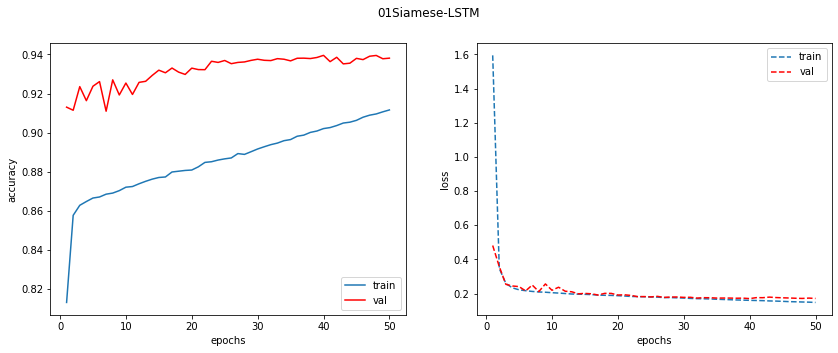

In [0]:
model_name = '01Siamese-LSTM'
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,checkpoint,early]
def SiaLSTM(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    TimeDenseLayer = TimeDistributed(Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.005),kernel_initializer='he_normal'))
    lstm_layer = LSTM(250,return_sequences=False,recurrent_regularizer=regularizers.l2(0.005),recurrent_dropout=0.2)
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    embedded1 = TimeDenseLayer(embedded1)
    embedded2 = TimeDenseLayer(embedded2)
    ddense1 = BatchNormalization()(embedded1)
    ddense2 = BatchNormalization()(embedded2)
    gru1 = lstm_layer(ddense1)
    gru2 = lstm_layer(ddense2)
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge1 = concatenate([DIST,BASE,TAG,VEC])
    Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
    Merge1 = BatchNormalization()(Merge1)
    MUL = multiply([gru1,gru2])
    DOT = dot([gru1,gru2],axes=1)
    SUB = subtract([gru1,gru2])
    SUB = Lambda(lambda x:x**2)(SUB)
    Merge2 = concatenate([gru1,gru2,MUL,DOT,SUB])
    Merge2 = BatchNormalization()(Merge2)
    Merge2 = Dropout(0.4)(Merge2)
    Merge2 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
    Merge = concatenate([Merge1,Merge2])
    Merge = Dropout(0.2)(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=Adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v1 = SiaLSTM(embedding_matrix)
plot_model(model_v1,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h1 = model_v1.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
          batch_size=2048, epochs=200, shuffle=True,
          validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          # validation_split=0.05,
          class_weight=class_weight,callbacks=callback)
plot_fit(h1,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

#### 4.3.2 dropout search

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 35, 300)      37947300    input_67[0][0]                   
                                                                 input_68[0][0]                   
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 35, 250)      75250       embedding_12[0][0]         

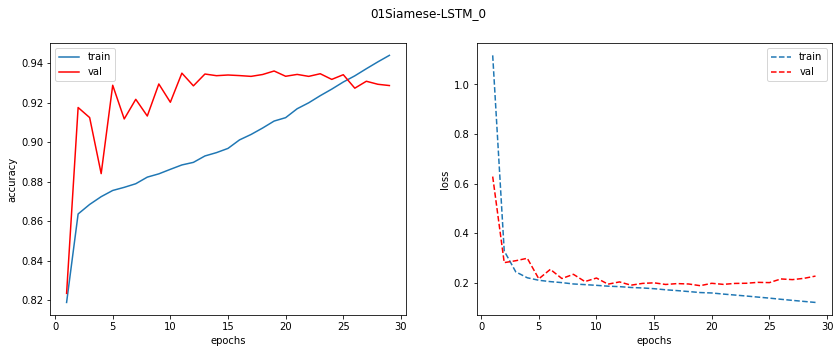

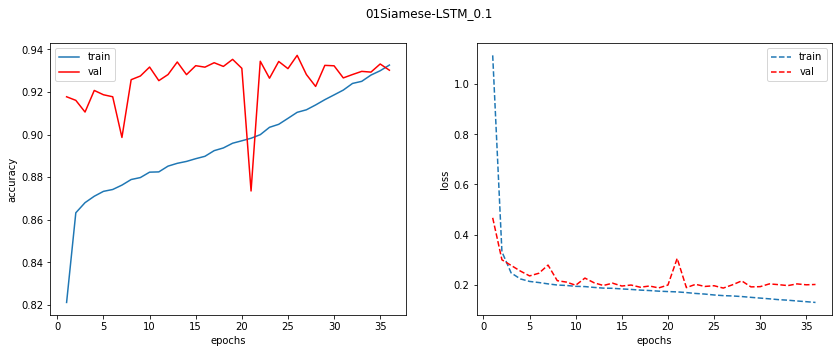

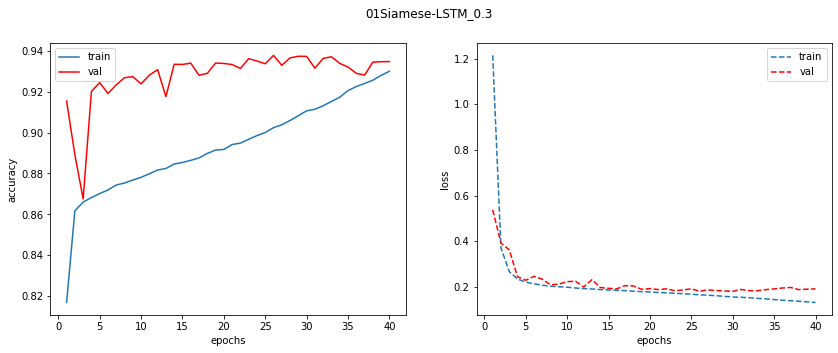

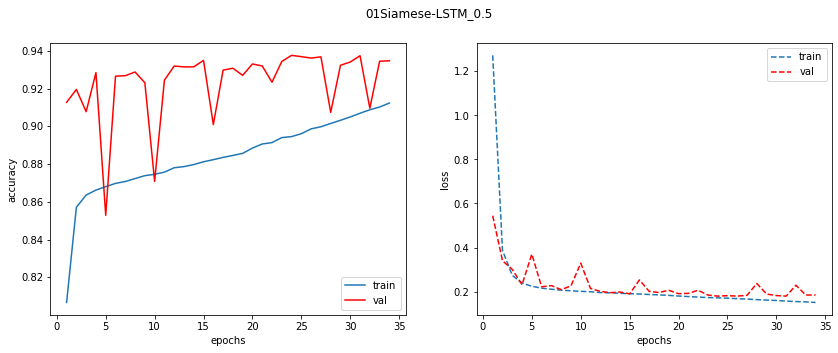

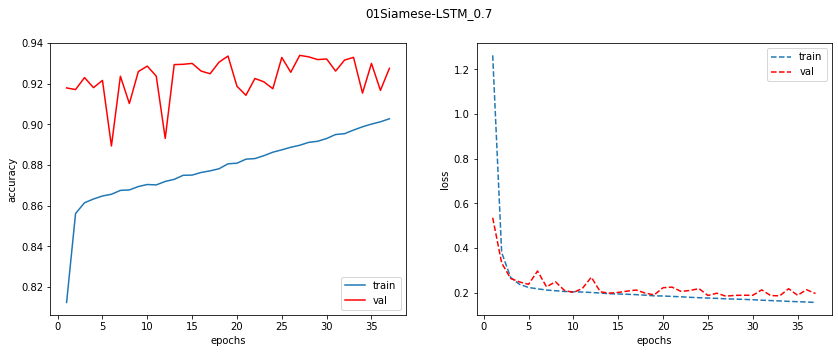

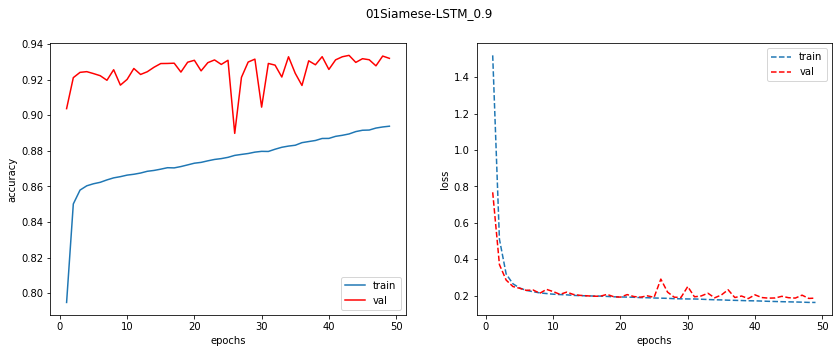

In [0]:
# search dropout
for DROPOUT in [0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    model_name = '01Siamese-LSTM_'+str(DROPOUT)
    early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
    checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
    callback = [reduce_lr,checkpoint,early]
    def SiaLSTM(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    TimeDenseLayer = TimeDistributed(Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.002),kernel_initializer='he_normal'))
    lstm_layer = LSTM(250,return_sequences=False,recurrent_regularizer=regularizers.l2(0.002),recurrent_dropout=0.2)
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    embedded1 = TimeDenseLayer(embedded1)
    embedded2 = TimeDenseLayer(embedded2)
    ddense1 = BatchNormalization()(embedded1)
    ddense2 = BatchNormalization()(embedded2)
    gru1 = lstm_layer(ddense1)
    gru2 = lstm_layer(ddense2)
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge1 = concatenate([DIST,BASE,TAG,VEC])
    Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
    Merge1 = BatchNormalization()(Merge1)
    MUL = multiply([gru1,gru2])
    DOT = dot([gru1,gru2],axes=1)
    DOT = Lambda(lambda x:K.repeat_elements(x,rep=100,axis=1))(DOT)
    SUB = subtract([gru1,gru2])
    SUB = Lambda(lambda x:x**2)(SUB)
    Merge2 = concatenate([gru1,gru2,MUL,DOT,SUB])
    Merge2 = BatchNormalization()(Merge2)
    Merge2 = Dropout(DROPOUT)(Merge2)
    Merge2 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
    Merge = concatenate([Merge1,Merge2])
    Merge = Dropout(0.2)(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=Adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
    t_start = time.time()
    model_v1 = SiaLSTM(embedding_matrix)
    h1 = model_v1.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
            batch_size=2048, epochs=200, shuffle=True,
            validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
            # validation_split=0.05,
            class_weight=class_weight,callbacks=callback)
    plot_fit(h1,model_name)
    dt = time.time() - t_start
    print('time cost:\t%.1fmin'%(dt/60))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using th

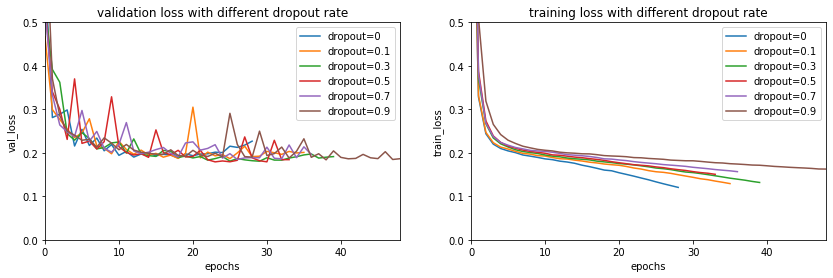

In [0]:
# visualization for dropout
plt.figure(figsize=(14,4))
for DROPOUT in [0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    model_name = '01Siamese-LSTM_'+str(DROPOUT)
    plt.subplot(121)
    plt.ylim([0,0.5])
    pd.read_csv(ModelPath+'/'+model_name+'.csv')['val_loss'].plot(label='dropout='+str(DROPOUT))
    plt.xlabel('epochs')
    plt.ylabel('val_loss')
    plt.title('validation loss with different dropout rate')
    plt.legend()
    plt.subplot(122)
    plt.ylim([0,0.5])
    pd.read_csv(ModelPath+'/'+model_name+'.csv')['loss'].plot(label='dropout='+str(DROPOUT))
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('train_loss')
    plt.title('training loss with different dropout rate')
plt.savefig(FigurePath+'/loss_dropout.png',dpi=300)

#### 4.3.3 reularization search

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 35, 300)      37947300    input_37[0][0]                   
                                                                 input_38[0][0]                   
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 35, 300)      90300       embedding_7[0][0]          

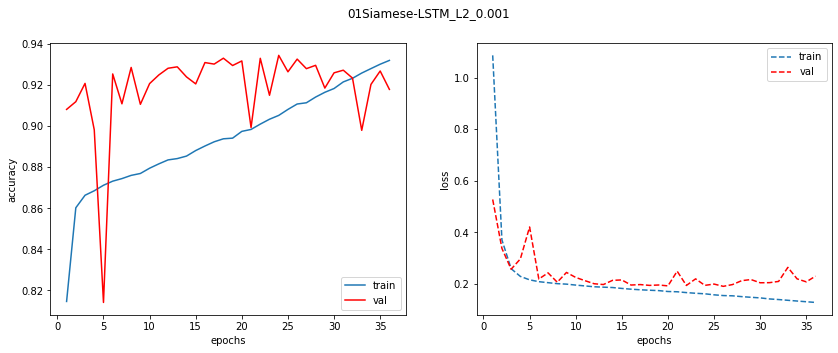

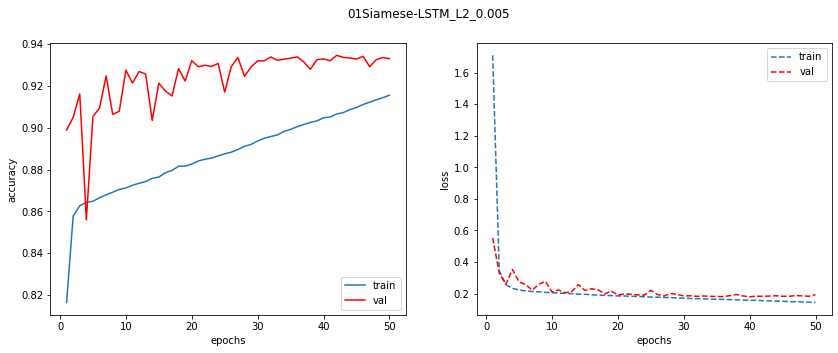

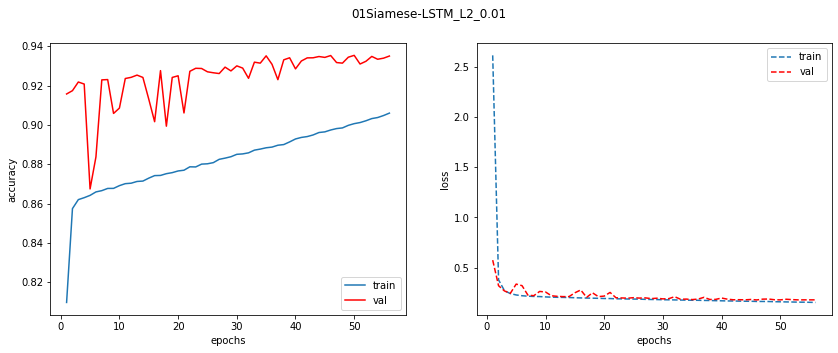

In [0]:
# search REGULARIZATION

for RATE in [0.001, 0.005, 0.01]:
    L = regularizers.l2(RATE)
    model_name = '01Siamese-LSTM_L2_'+str(RATE)
    early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
    checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
    callback = [reduce_lr,checkpoint,early]
    def SiaLSTM(embedding_matrix):
        X1 = Input(shape=(pad,))  
        X2 = Input(shape=(pad,))
        X_dist = Input(shape=(dist_feat.shape[1],))
        X_base = Input(shape=(base_feat.shape[1],))
        X_tag = Input(shape=(tag_feat.shape[1],))
        X_vec = Input(shape=(vec_feat.shape[1],))
        embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=pad,
                        trainable=False)
        TimeDenseLayer = TimeDistributed(Dense(300,activation='relu',kernel_regularizer=L,kernel_initializer='he_normal'))
        lstm_layer = LSTM(250,return_sequences=False,recurrent_regularizer=L,recurrent_dropout=0.2)
        embedded1 = embedded_layer(X1)
        embedded2 = embedded_layer(X2)
        embedded1 = TimeDenseLayer(embedded1)
        embedded2 = TimeDenseLayer(embedded2)
        ddense1 = BatchNormalization()(embedded1)
        ddense2 = BatchNormalization()(embedded2)
        gru1 = lstm_layer(ddense1)
        gru2 = lstm_layer(ddense2)
        DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
        BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
        TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
        VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
        Merge1 = concatenate([DIST,BASE,TAG,VEC])
        Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
        Merge1 = BatchNormalization()(Merge1)
        MUL = multiply([gru1,gru2])
        DOT = dot([gru1,gru2],axes=1)
        DOT = Lambda(lambda x:K.repeat_elements(x,rep=100,axis=1))(DOT)
        SUB = subtract([gru1,gru2])
        SUB = Lambda(lambda x:x**2)(SUB)
        Merge2 = concatenate([gru1,gru2,MUL,DOT,SUB])
        Merge2 = BatchNormalization()(Merge2)
        Merge2 = Dropout(0.4)(Merge2)
        Merge2 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
        Merge = concatenate([Merge1,Merge2])
        Merge = Dropout(0.2)(Merge)
        Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
        Y = Dense(1,activation='sigmoid')(Merge)
        model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
        model.compile(loss="binary_crossentropy",
                optimizer=Adam(0.001),
                metrics=['accuracy'])
        model.summary()
        return model
    t_start = time.time()
    model_v1 = SiaLSTM(embedding_matrix)
    h1 = model_v1.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
            batch_size=2048, epochs=200, shuffle=True,
            validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
            # validation_split=0.05,
            class_weight=class_weight,callbacks=callback)
    plot_fit(h1,model_name)
    dt = time.time() - t_start
    print('time cost:\t%.1fmin'%(dt/60))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

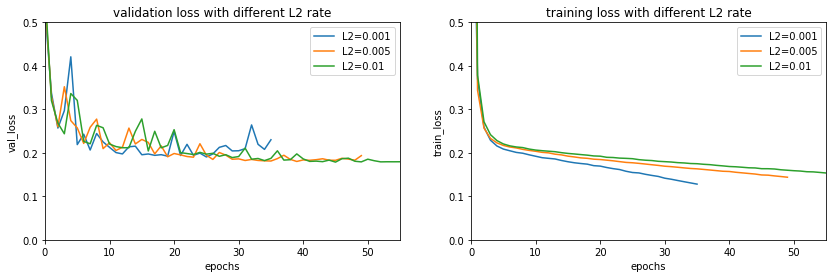

In [0]:
# visualization for dropout
plt.figure(figsize=(14,4))
for RATE in [0.001, 0.005, 0.01]:
    L = regularizers.l2(RATE)
    model_name = '01Siamese-LSTM_L2_'+str(RATE)
    plt.subplot(121)
    plt.ylim([0,0.5])
    pd.read_csv(ModelPath+'/'+model_name+'.csv')['val_loss'].plot(label='L2='+str(RATE))
    plt.xlabel('epochs')
    plt.ylabel('val_loss')
    plt.title('validation loss with different L2 rate')
    plt.legend()
    plt.subplot(122)
    plt.ylim([0,0.5])
    pd.read_csv(ModelPath+'/'+model_name+'.csv')['loss'].plot(label='L2='+str(RATE))
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('train_loss')
    plt.title('training loss with different L2 rate')
plt.savefig(FigurePath+'/loss_regularization.png',dpi=300)

#### 4.3.4 learning rate search

In [0]:
# search learning rate
for LR in [0.0003, 0.001, 0.005, 0.01]:
    model_name = '01Siamese-LSTM_LR_'+str(LR)
    early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
    checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
    callback = [reduce_lr,checkpoint,early]
    def SiaLSTM(embedding_matrix):
        X1 = Input(shape=(pad,))  
        X2 = Input(shape=(pad,))
        X_dist = Input(shape=(dist_feat.shape[1],))
        X_base = Input(shape=(base_feat.shape[1],))
        X_tag = Input(shape=(tag_feat.shape[1],))
        X_vec = Input(shape=(vec_feat.shape[1],))
        embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=pad,
                        trainable=False)
        TimeDenseLayer = TimeDistributed(Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.005),kernel_initializer='he_normal'))
        lstm_layer = LSTM(250,return_sequences=False,recurrent_regularizer=regularizers.l2(0.005),recurrent_dropout=0.2)
        embedded1 = embedded_layer(X1)
        embedded2 = embedded_layer(X2)
        embedded1 = TimeDenseLayer(embedded1)
        embedded2 = TimeDenseLayer(embedded2)
        ddense1 = BatchNormalization()(embedded1)
        ddense2 = BatchNormalization()(embedded2)
        gru1 = lstm_layer(ddense1)
        gru2 = lstm_layer(ddense2)
        DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
        BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
        TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
        VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
        Merge1 = concatenate([DIST,BASE,TAG,VEC])
        Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
        Merge1 = BatchNormalization()(Merge1)
        MUL = multiply([gru1,gru2])
        DOT = dot([gru1,gru2],axes=1)
        DOT = Lambda(lambda x:K.repeat_elements(x,rep=100,axis=1))(DOT)
        SUB = subtract([gru1,gru2])
        SUB = Lambda(lambda x:x**2)(SUB)
        Merge2 = concatenate([gru1,gru2,MUL,DOT,SUB])
        Merge2 = BatchNormalization()(Merge2)
        Merge2 = Dropout(0.4)(Merge2)
        Merge2 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
        Merge = concatenate([Merge1,Merge2])
        Merge = Dropout(0.2)(Merge)
        Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
        Y = Dense(1,activation='sigmoid')(Merge)
        model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
        model.compile(loss="binary_crossentropy",
                optimizer=Adam(LR),
                metrics=['accuracy'])
        model.summary()
        return model
    t_start = time.time()
    model_v1 = SiaLSTM(embedding_matrix)
    h1 = model_v1.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
            batch_size=2048, epochs=200, shuffle=True,
            validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
            # validation_split=0.05,
            class_weight=class_weight,callbacks=callback)
    plot_fit(h1,model_name)
    dt = time.time() - t_start
    print('time cost:\t%.1fmin'%(dt/60))

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 35, 300)      37947300    input_55[0][0]                   
                                                                 input_56[0][0]                   
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 35, 300)      90300       embedding_10[0][0]        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using th

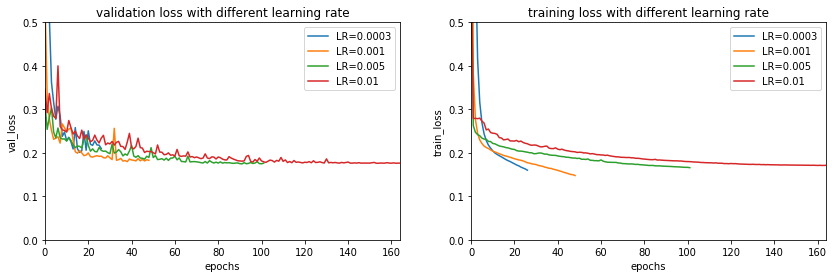

In [0]:
# visualization for learning rate
plt.figure(figsize=(14,4))
for LR in [0.0003, 0.001, 0.005, 0.01]:
    model_name = '01Siamese-LSTM_LR_'+str(LR)
    plt.subplot(121)
    plt.ylim([0,0.5])
    pd.read_csv(ModelPath+'/'+model_name+'.csv')['val_loss'].plot(label='LR='+str(LR))
    plt.xlabel('epochs')
    plt.ylabel('val_loss')
    plt.title('validation loss with different learning rate')
    plt.legend()
    plt.subplot(122)
    plt.ylim([0,0.5])
    pd.read_csv(ModelPath+'/'+model_name+'.csv')['loss'].plot(label='LR='+str(LR))
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('train_loss')
    plt.title('training loss with different learning rate')
plt.savefig(FigurePath+'/loss_LR.png',dpi=300)

#### 4.3.5 without magic feature

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      37947300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 35, 250)      75250       embedding_1[0][0]          

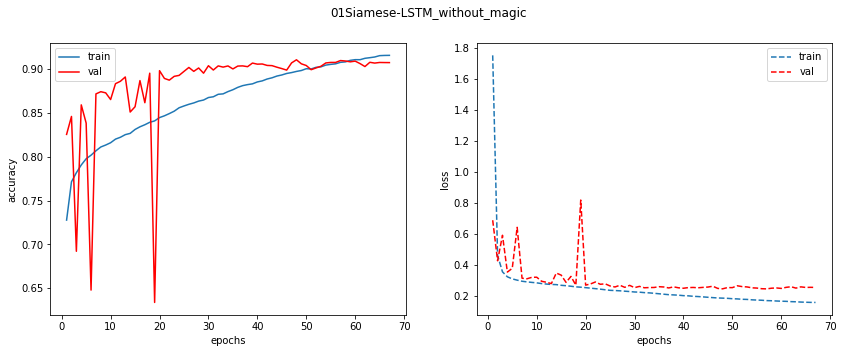

In [0]:
model_name = '01Siamese-LSTM_without_magic'
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,checkpoint,early]
def SiaLSTM(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    TimeDenseLayer = TimeDistributed(Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.005),kernel_initializer='he_normal'))
    lstm_layer = LSTM(250,return_sequences=False,recurrent_regularizer=regularizers.l2(0.005),recurrent_dropout=0.2)
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    embedded1 = TimeDenseLayer(embedded1)
    embedded2 = TimeDenseLayer(embedded2)
    ddense1 = BatchNormalization()(embedded1)
    ddense2 = BatchNormalization()(embedded2)
    gru1 = lstm_layer(ddense1)
    gru2 = lstm_layer(ddense2)
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge1 = concatenate([DIST,BASE,TAG,VEC])
    Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
    Merge1 = BatchNormalization()(Merge1)
    MUL = multiply([gru1,gru2])
    DOT = dot([gru1,gru2],axes=1)
    SUB = subtract([gru1,gru2])
    SUB = Lambda(lambda x:x**2)(SUB)
    Merge2 = concatenate([gru1,gru2,MUL,DOT,SUB])
    Merge2 = BatchNormalization()(Merge2)
    Merge2 = Dropout(0.4)(Merge2)
    Merge2 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
    Merge = concatenate([Merge1,Merge2])
    Merge = Dropout(0.2)(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=Adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v1 = SiaLSTM(embedding_matrix)
plot_model(model_v1,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h1 = model_v1.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
          batch_size=2048, epochs=200, shuffle=True,
          validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          # validation_split=0.05,
          class_weight=class_weight,callbacks=callback)
plot_fit(h1,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

### 4.4 Siamese-BiLSTM

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 35, 300)      37947300    input_31[0][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 35, 300)      90300       embedding_6[0][0]          

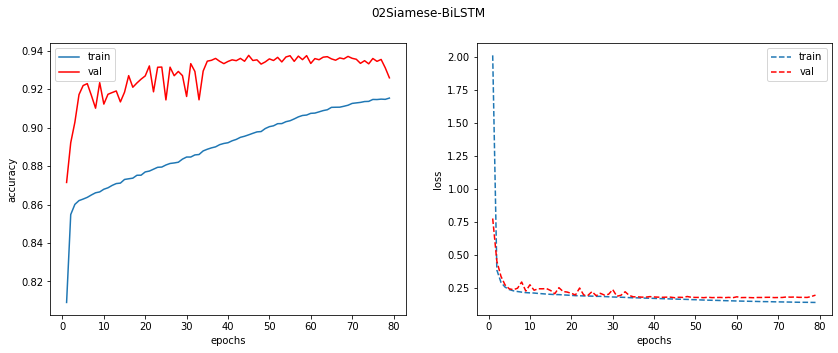

In [0]:
model_name = '02Siamese-BiLSTM'
early = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,checkpoint,early]
def SiaBiLSTM(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    TimeDenseLayer = TimeDistributed(Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    lstm_layer = Bidirectional(LSTM(250,return_sequences=False,recurrent_regularizer=regularizers.l2(0.01),recurrent_dropout=0.5))
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    embedded1 = TimeDenseLayer(embedded1)
    embedded2 = TimeDenseLayer(embedded2)
    ddense1 = BatchNormalization()(embedded1)
    ddense2 = BatchNormalization()(embedded2)
    gru1 = lstm_layer(ddense1)
    gru2 = lstm_layer(ddense2)
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge1 = concatenate([DIST,BASE,TAG,VEC])
    # Merge1 = Dropout(0.2)(Merge1)
    Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
    Merge1 = BatchNormalization()(Merge1)
    MUL = multiply([gru1,gru2])
    DOT = dot([gru1,gru2],axes=1)
    DOT = Lambda(lambda x:K.repeat_elements(x,rep=100,axis=1))(DOT)
    SUB = subtract([gru1,gru2])
    SUB = Lambda(lambda x:x**2)(SUB)
    Merge2 = concatenate([gru1,gru2,MUL,DOT,SUB])
    Merge2 = BatchNormalization()(Merge2)
    Merge2 = Dropout(0.5)(Merge2)
    Merge2 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
    Merge = concatenate([Merge1,Merge2])
    Merge = Dropout(0.2)(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=Adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v2 = SiaBiLSTM(embedding_matrix)
plot_model(model_v2,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h2 = model_v2.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
          batch_size=2048, epochs=300, shuffle=True,
          validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          # validation_split=0.05,
          class_weight=class_weight,callbacks=callback)
plot_fit(h2,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

### 4.5 Siamese-CNN_ARC1


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 300)      37947300    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 35, 300)      1200        embedding_2[0][0]         

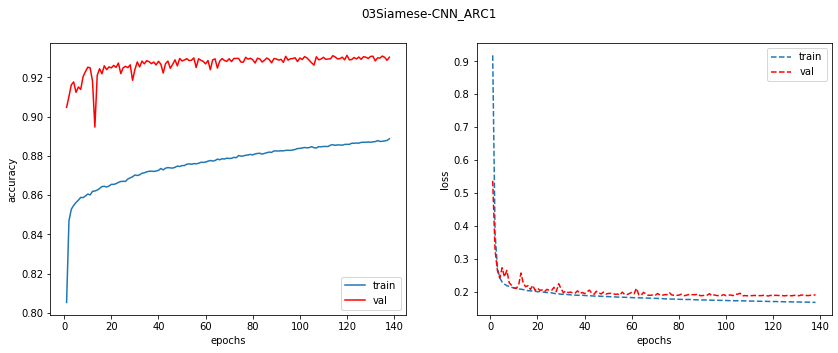

In [0]:
model_name = '03Siamese-CNN_ARC1'
early = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, mode='auto', factor=0.95)
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,checkpoint,early]
def SiaCNN_ARC1(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    sent1 = BatchNormalization()(embedded1)
    sent2 = BatchNormalization()(embedded2)
    CNN_2 = Conv1D(30,2,strides=1,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_normal')
    CNN_3 = Conv1D(30,3,strides=1,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_normal')
    CNN_4 = Conv1D(30,4,strides=1,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_normal')
    CNN_5 = Conv1D(30,5,strides=2,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_normal')
    CNN_6 = Conv1D(30,6,strides=2,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_normal')
    CNN_7 = Conv1D(30,7,strides=2,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_normal')
    # POOL = GlobalAveragePooling1D()
    sent1_cnn2 = GlobalAveragePooling1D()(CNN_2(sent1))
    sent2_cnn2 = GlobalAveragePooling1D()(CNN_2(sent2))
    sent1_cnn3 = GlobalAveragePooling1D()(CNN_3(sent1))
    sent2_cnn3 = GlobalAveragePooling1D()(CNN_3(sent2))
    sent1_cnn4 = GlobalAveragePooling1D()(CNN_4(sent1))
    sent2_cnn4 = GlobalAveragePooling1D()(CNN_4(sent2))
    sent1_cnn5 = GlobalAveragePooling1D()(CNN_5(sent1))
    sent2_cnn5 = GlobalAveragePooling1D()(CNN_5(sent2))
    sent1_cnn6 = GlobalAveragePooling1D()(CNN_6(sent1))
    sent2_cnn6 = GlobalAveragePooling1D()(CNN_6(sent2))
    sent1_cnn7 = GlobalAveragePooling1D()(CNN_7(sent1))
    sent2_cnn7 = GlobalAveragePooling1D()(CNN_7(sent2))
    sent1_cnn = concatenate([sent1_cnn2,sent1_cnn3,sent1_cnn4,sent1_cnn5,sent1_cnn6,sent1_cnn7])
    sent2_cnn = concatenate([sent2_cnn2,sent2_cnn3,sent2_cnn4,sent2_cnn5,sent2_cnn6,sent2_cnn7])
    Merge1_diff = subtract([sent1_cnn,sent2_cnn])
    Merge1_diff = Lambda(lambda x: K.abs(x))(Merge1_diff)
    Merge1_mul = multiply([sent1_cnn,sent2_cnn])
    Merge1_dot = dot([sent1_cnn,sent2_cnn],axes=1)
    Merge1_dot = Lambda(lambda x:K.repeat_elements(x,60,axis=1))(Merge1_dot)
    Merge1 = concatenate([Merge1_diff,Merge1_dot,Merge1_mul])
    Merge1 = BatchNormalization()(Merge1)
    Merge1 = Dropout(0.1)(Merge1)
    Merge1 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge2 = concatenate([DIST,BASE,TAG,VEC])
    # Merge1 = Dropout(0.1)(Merge1)
    Merge2 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
    Merge2 = BatchNormalization()(Merge2)
    Merge = concatenate([Merge1,Merge2])
    Merge = Dropout(0.1)(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=Adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v3 = SiaCNN_ARC1(embedding_matrix)
plot_model(model_v3,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h3 = model_v3.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
          batch_size=2048, epochs=300, shuffle=True,
          validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          # validation_split=0.05,
          class_weight=class_weight,callbacks=callback)
plot_fit(h3,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

### 4.6 Siamese-CNN_ARC2


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      37947300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 35, 300)      1200        embedding_1[0][0]         

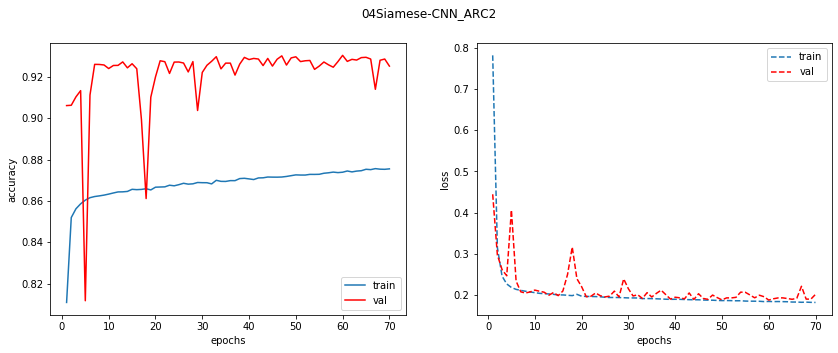

In [0]:
model_name = '04Siamese-CNN_ARC2'
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, mode='auto', factor=0.95)
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,checkpoint,early]
def SiaCNN_ARC2(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    sent1 = BatchNormalization()(embedded1)
    sent2 = BatchNormalization()(embedded2)
    # CNN_2 = Conv1D(10,2,strides=1,activation='relu',padding='same',kernel_initializer='he_normal')
    CNN_3 = Conv1D(10,3,strides=1,activation='relu',padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.005))
    CNN_4 = Conv1D(10,4,strides=1,activation='relu',padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.005))
    CNN_5 = Conv1D(10,5,strides=1,activation='relu',padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.005))
    # CNN_6 = Conv1D(10,6,strides=1,activation='relu',padding='same',kernel_initializer='he_normal')
    # CNN_7 = Conv1D(20,7,strides=1,activation='relu',padding='same',kernel_initializer='he_normal')
    POOL = MaxPooling1D(2)
    sent1_cnn3 = Reshape((pad,1,-1))(CNN_3(sent1))
    sent2_cnn3 = Reshape((1,pad,-1))(CNN_3(sent2))
    sent1_cnn3 = Lambda(lambda x:K.repeat_elements(x,rep=pad,axis=2))(sent1_cnn3)
    sent2_cnn3 = Lambda(lambda x:K.repeat_elements(x,rep=pad,axis=1))(sent2_cnn3)
    sent_matrix3 = concatenate([sent1_cnn3,sent2_cnn3],axis=-1)
    sent_matrix3 = BatchNormalization()(sent_matrix3)
    sent_matrix3 = Conv2D(50,(2,2),strides=2,activation='relu',kernel_regularizer=regularizers.l2(0.002))(sent_matrix3)
    sent_matrix3 = GlobalAveragePooling2D()(sent_matrix3)
    sent1_cnn4 = Reshape((pad,1,-1))(CNN_4(sent1))
    sent2_cnn4 = Reshape((1,pad,-1))(CNN_4(sent2))
    sent1_cnn4 = Lambda(lambda x:K.repeat_elements(x,rep=pad,axis=2))(sent1_cnn4)
    sent2_cnn4 = Lambda(lambda x:K.repeat_elements(x,rep=pad,axis=1))(sent2_cnn4)
    sent_matrix4 = concatenate([sent1_cnn4,sent2_cnn4],axis=-1)
    sent_matrix4 = BatchNormalization()(sent_matrix4)
    sent_matrix4 = Conv2D(50,(2,2),strides=2,activation='relu',kernel_regularizer=regularizers.l2(0.002))(sent_matrix4)
    sent_matrix4 = GlobalAveragePooling2D()(sent_matrix4)
    sent1_cnn5 = Reshape((pad,1,-1))(CNN_5(sent1))
    sent2_cnn5 = Reshape((1,pad,-1))(CNN_5(sent2))
    sent1_cnn5 = Lambda(lambda x:K.repeat_elements(x,rep=pad,axis=2))(sent1_cnn5)
    sent2_cnn5 = Lambda(lambda x:K.repeat_elements(x,rep=pad,axis=1))(sent2_cnn5)
    sent_matrix5 = concatenate([sent1_cnn5,sent2_cnn5],axis=-1)
    sent_matrix5 = BatchNormalization()(sent_matrix5)
    sent_matrix5 = Conv2D(50,(2,2),strides=2,activation='relu',kernel_regularizer=regularizers.l2(0.002))(sent_matrix5)
    sent_matrix5 = GlobalAveragePooling2D()(sent_matrix5)
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge1 = concatenate([DIST,BASE,TAG,VEC])
    Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
    Merge1 = BatchNormalization()(Merge1)
    Merge2 = concatenate([sent_matrix3,sent_matrix4,sent_matrix5])
    Merge2 = BatchNormalization()(Merge2)
    Merge2 = Dropout(0.4)(Merge2)
    Merge2 = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
    Merge = concatenate([Merge1,Merge2])
    Merge = Dropout(0.1)(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=Adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v4 = SiaCNN_ARC2(embedding_matrix)
plot_model(model_v4,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h4 = model_v4.fit([Q1_train,Q2_train,dist_feat_train,base_feat_train,tag_feat_train,vec_feat_train], Y_train, 
          batch_size=2048, epochs=300, shuffle=True,
          validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          # validation_split=0.05,
          class_weight=class_weight,callbacks=callback)
plot_fit(h4,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

### 4.7 class_weights effect












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      37947300    input_1[0][0]                    
                                                                 inp

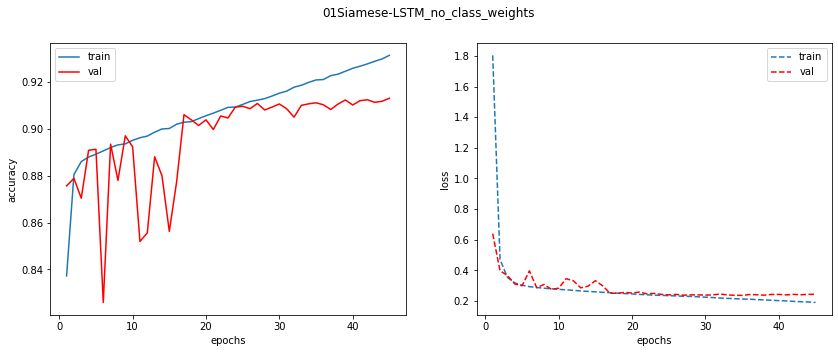

In [0]:
model_name = '01Siamese-LSTM_no_class_weights'
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, mode='auto', factor=0.95)
checkpoint = ModelCheckpoint(ModelPath+'/'+str(model_name)+'_best.h5', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
callback = [reduce_lr,checkpoint,early]
def SiaLSTM(embedding_matrix):
    X1 = Input(shape=(pad,))  
    X2 = Input(shape=(pad,))
    X_dist = Input(shape=(dist_feat.shape[1],))
    X_base = Input(shape=(base_feat.shape[1],))
    X_tag = Input(shape=(tag_feat.shape[1],))
    X_vec = Input(shape=(vec_feat.shape[1],))
    embedded_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=pad,
                     trainable=False)
    TimeDenseLayer = TimeDistributed(Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.005),kernel_initializer='he_normal'))
    lstm_layer = LSTM(250,return_sequences=False,recurrent_regularizer=regularizers.l2(0.005),recurrent_dropout=0.2)
    embedded1 = embedded_layer(X1)
    embedded2 = embedded_layer(X2)
    embedded1 = TimeDenseLayer(embedded1)
    embedded2 = TimeDenseLayer(embedded2)
    ddense1 = BatchNormalization()(embedded1)
    ddense2 = BatchNormalization()(embedded2)
    gru1 = lstm_layer(ddense1)
    gru2 = lstm_layer(ddense2)
    DIST = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_dist)
    BASE = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_base)
    TAG = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_tag)
    VEC = Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001))(X_vec)
    Merge1 = concatenate([DIST,BASE,TAG,VEC])
    Merge1 = Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge1)
    Merge1 = BatchNormalization()(Merge1)
    MUL = multiply([gru1,gru2])
    DOT = dot([gru1,gru2],axes=1)
    SUB = subtract([gru1,gru2])
    SUB = Lambda(lambda x:x**2)(SUB)
    Merge2 = concatenate([gru1,gru2,MUL,DOT,SUB])
    Merge2 = BatchNormalization()(Merge2)
    Merge2 = Dropout(0.4)(Merge2)
    Merge2 = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge2)
    Merge = concatenate([Merge1,Merge2])
    Merge = Dropout(0.2)(Merge)
    Merge = Dense(150,activation='relu',kernel_regularizer=regularizers.l2(0.001))(Merge)
    Y = Dense(1,activation='sigmoid')(Merge)
    model = Model(inputs=[X1,X2,X_dist,X_base,X_tag,X_vec], outputs=Y)
    model.compile(loss="binary_crossentropy",
            optimizer=Adam(0.001),
            metrics=['accuracy'])
    model.summary()
    return model
t_start = time.time()
model_v1 = SiaLSTM(embedding_matrix)
plot_model(model_v1,
      to_file=ModelPath + '//' +model_name + '.png',
      show_shapes=True,
      show_layer_names=False,
      dpi=150)
h1 = model_v1.fit([Q1,Q2,dist_feat,base_feat,tag_feat,vec_feat], train_Y, 
          batch_size=2048, epochs=200, shuffle=True,
        #   validation_data=([Q1_val,Q2_val,dist_feat_val,base_feat_val,tag_feat_val,vec_feat_val],Y_val),
          validation_split=0.05,
        #   class_weight=class_weight,
          callbacks=callback)
plot_fit(h1,model_name)
dt = time.time() - t_start
print('time cost:\t%.1fmin'%(dt/60))

## Prediction

In [0]:
# load test feature
print('start load test data at\t',datetime.datetime.now())
test_magic_feature = pd.read_pickle(datapath+'/test_magic_feature.pkl')
test_base_feature = pd.read_pickle(datapath+'/test_base_feature.pkl')     # 13列
test_fuzz_feature = pd.read_pickle(datapath+'/test_fuzz_feature.pkl')     # 8列
test_sentiment = pd.read_pickle(datapath+'/test_sentiment.pkl')        # 6列
# test_wmd = pd.read_pickle(datapath+'/test_wmd.pkl')              # 2列
test_embedding = pd.read_pickle(datapath+'/test_embedding.pkl')        # 30列(300)
embedding_matrix = np.loadtxt(ModelPath+'/embedding_matrix_fasttext.txt')
test_dist_emb = pd.read_pickle(datapath+'/test_dist_emb.pkl')         # 11列
# test_tag_vec_emb = pd.read_pickle(datapath+'/test_tag_vec_emb.pkl')      # 100列
test_diff_vec_bow = pd.read_pickle(datapath+'/test_diff_vec_bow.pkl')     # 100列
test_tag_vec_bow = pd.read_pickle(datapath+'/test_tag_vec_bow.pkl')      # 33列
test_q1v_tfidf = pd.read_pickle(datapath+'/test_q1v_tfidf.pkl')        # 100列
test_q2v_tfidf = pd.read_pickle(datapath+'/test_q2v_tfidf.pkl')        # 100列
test_dist_tfidf = pd.read_pickle(datapath+'/test_dist_tfidf.pkl')       # 11列
RawDF, TestDF = load_data()
try:
    test_base_feature.drop(columns=['base_q1_len','base_q2_len','base_q1_word','base_q2_word','base_q1_char','base_q2_char'],inplace=True)
except: pass
try:
    test_sentiment['diff_polarity'] = test_sentiment.apply(lambda x: abs(x['q1_polarity']-x['q2_polarity']),axis=1)
    test_sentiment['diff_subject'] = test_sentiment.apply(lambda x: abs(x['q1_subject']-x['q2_subject']),axis=1)
    test_sentiment.drop(columns=['q1_polarity','q2_polarity','q1_subject','q2_subject'],inplace=True)
except: pass
try:
    test_diff_tfidf = (test_q1v_tfidf-test_q2v_tfidf).abs()
except: pass
try:
    test_dist_tfidf['skew_diff_tf'] = (test_dist_tfidf['q1_skew_tf'] - test_dist_tfidf['q2_skew_tf']).abs()
    test_dist_tfidf['kur_diff_tf'] = (test_dist_tfidf['q1_kur_tf'] - test_dist_tfidf['q2_kur_tf']).abs()
    test_dist_tfidf.drop(columns=['q1_skew_tf','q2_skew_tf','q1_kur_tf','q2_kur_tf'],inplace=True)
except: pass

train_length = len(RawDF)
test_length = len(TestDF)
print('load test data finished at\t',datetime.datetime.now())
# data preparation
Q1 = np.zeros((test_length, pad))
Q2 = np.zeros((test_length, pad))
for i in range(test_length):
    Q1[i,:] = test_embedding['question1'].loc[i]
    Q2[i,:] = test_embedding['question2'].loc[i]
dist_feat = pd.concat([test_dist_tfidf,test_dist_emb],axis=1)
base_feat = pd.concat([test_magic_feature,test_base_feature,test_fuzz_feature,test_sentiment],axis=1)
tag_feat = pd.concat([test_tag_vec_bow],axis=1)
vec_feat = pd.concat([test_diff_vec_bow,test_diff_tfidf],axis=1)
# fill NA
for col in dist_feat.keys():
    dist_feat[col].fillna(2*dist_feat[col].max(),inplace=True)
# for col in base_feat.keys():
#   base_feat[col].fillna(10*base_feat[col].max(),inplace=True)
print(dist_feat.shape,base_feat.shape,tag_feat.shape,vec_feat.shape)
# best_model prediction


start load test data at	 2019-12-03 12:33:24.004491
load test data finished at	 2019-12-03 12:36:42.747853
(2345796, 20) (2345796, 21) (2345796, 34) (2345796, 130)


In [0]:
# no magic
model_name = '01Siamese-LSTM_without_magic'
test_model = load_model(ModelPath+'/'+str(model_name)+'_best.h5')
dist_feat = pd.concat([test_dist_tfidf,test_dist_emb],axis=1)
base_feat = pd.concat([test_base_feature,test_fuzz_feature,test_sentiment],axis=1)
tag_feat = pd.concat([test_tag_vec_bow],axis=1)
vec_feat = pd.concat([test_diff_vec_bow,test_diff_tfidf],axis=1)
testY = test_model.predict([Q1,Q2,dist_feat,base_feat,tag_feat,vec_feat],batch_size=1024*4,verbose=1)
submission = testY.copy()
test_id = [i for i in range(len(submission))]
sampleDF = pd.DataFrame({"test_id":test_id,
            "is_duplicate":submission.reshape(-1,)})
sampleDF.to_csv(datapath + '/result_'+model_name+'.csv',index=False)
print()

2345796/2345796 [==============================] - 83s 35us/step



In [0]:
# prediction of different model
from keras.models import load_model
base_feat = pd.concat([test_magic_feature,test_base_feature,test_fuzz_feature,test_sentiment],axis=1)
for model_name in ['00base_LR_without_embedding','00base_LR','01Siamese-LSTM','02Siamese-BiLSTM','03Siamese-CNN_ARC1']:
    print(model_name+':')
    if model_name=='00base_LR_without_embedding':
        test_model = load_model(ModelPath+'/'+str(model_name)+'_best.h5')
        testY = test_model.predict([dist_feat,base_feat,tag_feat,vec_feat],batch_size=1024*4,verbose=1)
    else:
        test_model = load_model(ModelPath+'/'+str(model_name)+'_best.h5')
        testY = test_model.predict([Q1,Q2,dist_feat,base_feat,tag_feat,vec_feat],batch_size=1024*4,verbose=1)
    submission = testY.copy()
    test_id = [i for i in range(len(submission))]
    sampleDF = pd.DataFrame({"test_id":test_id,
                "is_duplicate":submission.reshape(-1,)})
    sampleDF.to_csv(datapath + '/result_'+str(model_name)+'.csv',index=False)
    print()

00base_LR_without_embedding:


ValueError: ignored

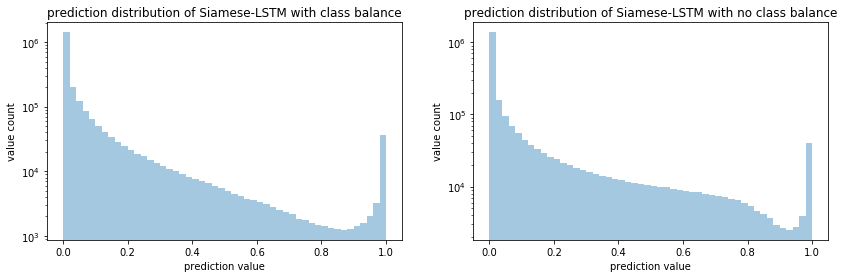

In [0]:
# class weights importance
from keras.models import load_model
model_LSTM = load_model(ModelPath+'/01Siamese-LSTM_best.h5')
model_NO_CLASS_WEIGHTS = load_model(ModelPath+'/01Siamese-LSTM_no_class_weights_best.h5')
Y1 = model_LSTM.predict([Q1,Q2,dist_feat,base_feat,tag_feat,vec_feat],batch_size=1024*4,verbose=1)
Y2 = model_NO_CLASS_WEIGHTS.predict([Q1,Q2,dist_feat,base_feat,tag_feat,vec_feat],batch_size=1024*4,verbose=1)
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(Y1,kde=False)
plt.xlabel('prediction value')
plt.ylabel('value count')
plt.yscale('log')
plt.title('prediction distribution of Siamese-LSTM with class balance')
plt.subplot(122)
sns.distplot(Y2,kde=False)
plt.xlabel('prediction value')
plt.ylabel('value count')
plt.yscale('log')
plt.title('prediction distribution of Siamese-LSTM with no class balance')
plt.savefig(FigurePath+'/prediction_ditribution_balance.png',dpi=300)
test_id = [i for i in range(len(Y1))]
pd.DataFrame({"test_id":test_id,
        "is_duplicate":Y1.reshape(-1,)}).to_csv(datapath + '/result_balance.csv',index=False)
pd.DataFrame({"test_id":test_id,
        "is_duplicate":Y2.reshape(-1,)}).to_csv(datapath + '/result_no_balance.csv',index=False)